---------------------------------------
Ippokratis Pantelidis  
Department of Informatics   
Athens University of Economics and Business  
p3210150@aueb.gr   

---------------------------------------

# Exploring AirBnB in Europe

A lot has been said and written about the effect of AirBnB around the world. In this assignment, you will use the data collected by [Inside AirBnB](http://insideairbnb.com).

Once you do that, spend some time familiarizing yourself with the data and then go ahead and do the following tasks. In the following questions, you will use data for the following cities:

* Amsterdam

* Athens

* Barcelona

* Berlin

* Copenhagen

* Dublin

* Lisbon

* London

* Madrid

* Paris

* Rome

* Venice

* Vienna

You will use the data for the latest 12 months period for which data is available.

## Imports

We will begin by importing some standard libraries that we've covered in our lessons. These libraries are essential for data manipulation and visualization

In [ ]:
# system and file operations
import os
import requests
import gdown

# data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# interactive widgets
import ipywidgets as widgets
from IPython.display import display

# web scraping
from bs4 import BeautifulSoup

## Data Collection

All the necessary data for the 13 cities of interest is available in the following Google Drive folder.

In [ ]:
folder_id = "1HCHIfx-Wp8ciGWNBp3cHVRRkLsOwcl0T"
drive_url = f"https://drive.google.com/drive/folders/{folder_id}"

We will retrieve the data for the 13 cities from the Google Drive folder and load it into our workspace.

In [ ]:
gdown.download_folder(id=folder_id, quiet=False)


We’ve set up a directory named `data` within our file system, from which our dataset is now accessible via the following path.

In [ ]:
city_data_path = "/content/data/cities"  # remove /collab/ if not in google collab

Within the `data_path`, you will find a separate folder for each city, each containing all the required data.

In [ ]:
cities = os.listdir(city_data_path)
cities

['Amsterdam',
 'Athens',
 'Barcelona',
 'Dublin',
 'Lisbon',
 'London',
 'Madrid',
 'Paris',
 'Rome',
 'Venice',
 'Vienna',
 'Berlin',
 'Copenhagen']

We'll maintain a list of the 13 cities we intend to examine, making it more convenient to reference them as we move forward with our work.

It is important to note that Inside Airbnb provides data on a quarterly basis. Since our analysis will cover the last 12 months, we need to load data from all four quarters. Each city folder inside the `data` folder in our workspace contains four `.csv` files, with each file named according to the quarter it represents. This structure allows us to access and combine data from all quarters to ensure a complete dataset for the past year.

## Listings Data

To start, we will gather the listings for each city and organize them into a dictionary. Each dictionary entry will map a city to a DataFrame that combines the data from its corresponding Q1–Q4 CSV files. The resulting format will be as follows: `{city: concatenated dataframe}`.

In [ ]:
def load_listings_csv(city):
    file_names = ['listings-q1.csv', 'listings-q2.csv', 'listings-q3.csv', 'listings-q4.csv']
    csv_files = []

    for file_name in file_names:
        file_path = os.path.join(city_data_path, city, file_name)
        if os.path.exists(file_path):
            csv_files.append(pd.read_csv(file_path))

    if csv_files:
        combined_df = pd.concat(csv_files, ignore_index=True)
        return combined_df
    else:
        return pd.DataFrame()

listings_dict = {city: load_listings_csv(city) for city in cities}

To help identify each DataFrame by city, we'll add a new column named 'city' to all the DataFrames, which will indicate the corresponding city for each listing.

In [ ]:
listings_dict = {city: df.assign(city=city) for city, df in listings_dict.items()}

Since each listing now has city information, we can drop the dictionary and combine all the DataFrames into a single one.

In [ ]:
listings_df = pd.concat(listings_dict.values(), ignore_index=True)
listings_df.shape

(1445976, 19)

We can see that the dataset consists of **1,445,976 observations** and **19 features**.

The large number of entries in our data may be due to duplicates, as listings from the same city may appear in multiple quarters. This occurs when the same listings are re-listed in different quarters throughout the year, resulting in duplicate entries across the quarterly files. To address this, we’ll need to identify and remove duplicates, retaining only unique listings based on relevant identifiers (e.g., listing_id).

In [ ]:
listings_df = listings_df.drop_duplicates(subset=['id', 'city'])
listings_df.shape

(487803, 19)

After removing duplicate entries based on the same `id` and `city` using the `drop_duplicates` method with the `subset` argument, our filtered dataset now contains **487,803 observations** and **19 features**.

Now, we will use the `.info()` method to gain a better understanding of our dataset. This method provides us with key insights, including:

- The names of the columns in the DataFrame
- The count of non-null values in each column
- The data types (dtypes) for each column

In [ ]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 487803 entries, 0 to 1445975
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              487803 non-null  int64  
 1   name                            487803 non-null  object 
 2   host_id                         487803 non-null  int64  
 3   host_name                       487739 non-null  object 
 4   neighbourhood_group             114837 non-null  object 
 5   neighbourhood                   487803 non-null  object 
 6   latitude                        487803 non-null  float64
 7   longitude                       487803 non-null  float64
 8   room_type                       487803 non-null  object 
 9   price                           448645 non-null  float64
 10  minimum_nights                  487803 non-null  int64  
 11  number_of_reviews               487803 non-null  int64  
 12  last_review         

- The dataset is largely complete, with most columns containing all the necessary information for our analysis, except for a few columns that have missing values.

- We observe that `host_name`, `last_review`, `reviews_per_month`, and `license` have some missing entries, which we will note for potential impact on our analysis later.

- The `neighbourhood_group` column has a significant number of null entries, indicating a lack of data that may require further investigation.

- The data types are mostly appropriate, with four columns as `float64`, seven as `int64`, and eight as `object`. We can treat the object data types as strings without the need for conversion.

Let's see a sample of 5 random listings from our dataset to get a sense of the data structure and values.

In [ ]:
listings_df.sample(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,city
345651,30525473,Rental unit in Greater London · 12 bedrooms · ...,7363078,Ilja,NaN,Hackney,51.53029,-0.087100,Private room,29.0,3,0,NaN,NaN,1,0,0,NaN,London
1272493,17146642,Rental unit in Vienna · ★4.87 · 1 bedroom · 1 ...,107997171,Sonja-Maria,NaN,Landstra§e,48.20678,16.392450,Private room,49.0,2,161,2020-12-11,1.95,11,0,0,NaN,Vienna
332844,16545406,Rental unit in London · 1 bedroom · 1 bed · 1 ...,13238860,Gabriel,NaN,Westminster,51.51135,-0.186370,Private room,50.0,1,0,NaN,NaN,1,0,0,NaN,London
705651,1066837911362578189,Habitación en Retiro,336298582,Valeriya,Retiro,Pacífico,40.40646,-3.684430,Private room,55.0,1,7,2024-03-10,3.23,1,257,7,NaN,Madrid
1269766,1203684625533115288,Venice Rooms - Pink,589978104,Lisa,Isole,Cannaregio,45.44578,12.328467,Private room,180.0,1,2,2024-09-02,2.00,3,64,2,NaN,Venice


## AirBnB Listings

Find the number of AirBnB listings per city. Show the information in tabular format, and also make a plot.

To achieve this, we will group the listings in the DataFrame by the `city` column and count the number of listings for each city. This process will create a new DataFrame that contains two columns: one for the city names and another for the count of listings in each city, labeled as "`num_listings`."

In [ ]:
listings_per_city = listings_df.groupby('city').size().reset_index(name='num_listings')
listings_per_city

,city,num_listings
0,Amsterdam,11342
1,Athens,17112
2,Barcelona,24860
3,Berlin,15830
4,Copenhagen,24927
5,Dublin,12196
6,Lisbon,28914
7,London,129659
8,Madrid,35542
9,Paris,118804


Now, we will call the `.describe()` method on our `num_listings` column to summarize the statistics of the number of listings per city. The output will provide us with the following key metrics:

- count: The total number of entries in the column (indicating how many cities have listings).
- mean: The average number of listings across all cities.
- std: The standard deviation, showing the variation from the mean.
- min: The lowest number of listings found in any city.
- 25%: The first quartile (25th percentile), indicating that 25% of the cities have this number of listings or fewer.
- 50% (median): The median number of listings, meaning that half of the cities have this number of listings or fewer.
- 75%: The third quartile (75th percentile), indicating that 75% of the cities have this number of listings or fewer.
- max: The highest number of listings in any city.

In [ ]:
listings_per_city['num_listings'].describe()

,num_listings
count,13.000000
mean,37523.307692
std,39596.539427
min,9691.000000
25%,15830.000000
50%,24860.000000
75%,35542.000000
max,129659.000000


Overall, these statistics reveal noticeable differences in the number of listings among the cities.

We’ll start by visualizing the number of listings per city with a **bar plot**. Each city will have a bar on the horizontal axis, with the height representing the number of listings on the vertical axis. This will give us a clear view of how listings compare across cities.

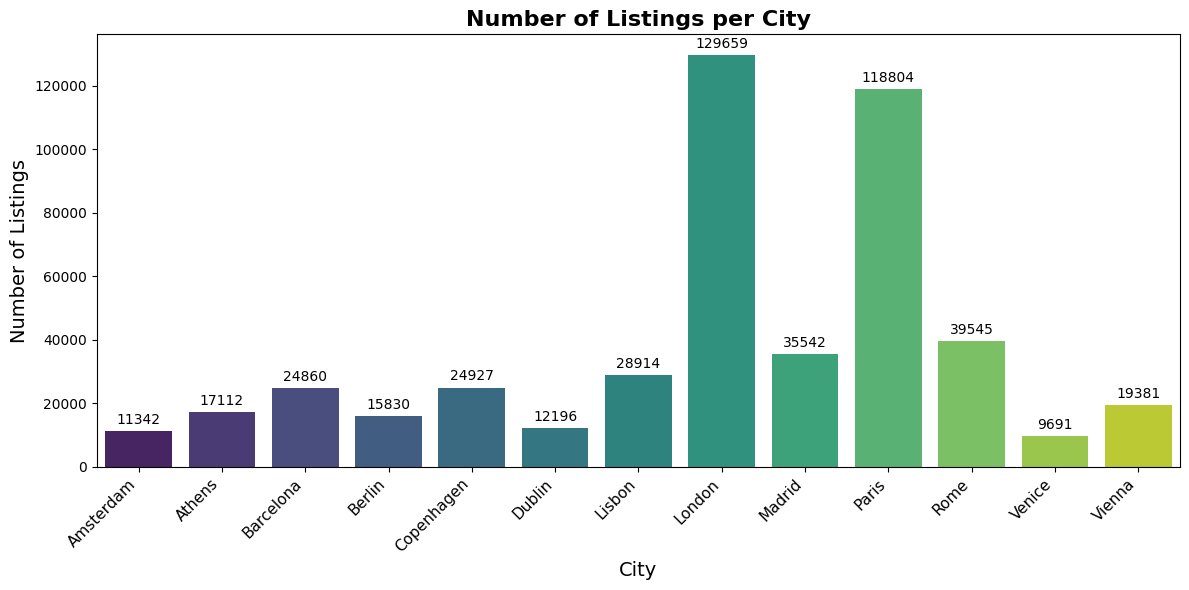

In [ ]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=listings_per_city, x='city', y='num_listings', hue='city', palette="viridis", dodge=False, legend=False)

for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10, padding=3) # display the number of listings at the top edge of each bar

plt.xticks(rotation=45, ha='right', fontsize=11)
plt.title('Number of Listings per City', fontsize=16, weight='bold')
plt.xlabel('City', fontsize=14)
plt.ylabel('Number of Listings', fontsize=14)

plt.tight_layout()
plt.show()


*London* and *Paris* clearly have the highest number of listings, far outpacing other cities. *Madrid* and *Rome* follow at a distance, with a moderately high listing count compared to the rest. Cities like *Lisbon*, *Copenhagen* and *Barcelona* also have substantial numbers, though significantly lower than the top two. On the lower end, cities such as *Venice* and *Amsterdam* have fewer listings, suggesting a smaller rental market relative to the larger cities.

Next, we’ll visualize the listings data using a **pie chart** to clearly show the percentage share of listings for each city. This will provide an intuitive view of how the listings are distributed across the different cities.

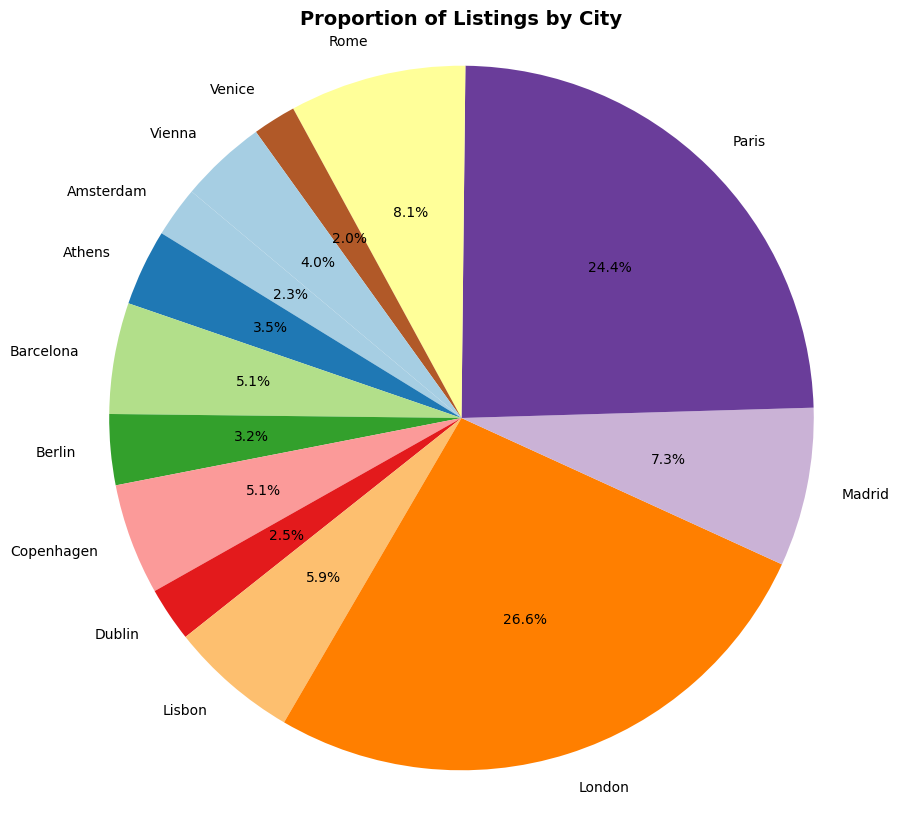

In [ ]:
plt.figure(figsize=(10, 10))
plt.pie(
    listings_per_city['num_listings'],
    labels=listings_per_city['city'],
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors
)

plt.title('Proportion of Listings by City', fontsize=14, weight='bold')
plt.axis('equal')

plt.show()

The proportions in the pie chart above further confirm our findings.

## AirBnB Densities

Apart from the number of distinct listings, we are interested in the density, that is, the number of AirBnB listings per 1,000 inhabitants, again for the latest 12 months period for which data is available. You must determine the number of inhabitants per city in the most appropriate way. Show the information in tabular format, and also make a plot.

To obtain the population of each city in the most effective way, we should make an API call or retrieve data from a database. We will proceed with the first method by accessing the City API from Ninjas API (https://api-ninjas.com/api/city) , which provides valuable and up-to-date information about many cities around the world, including population data we need.

The result of an API call to the City API, after providing the city name, is returned in the following format:

```
[
  {
    "name": "",
    "latitude": ,
    "longitude": ,
    "country": "",
    "population": ,
    "region": "",
    "is_capital":
  }
]
```
Since we are only interested in the population, we will extract and keep just that part of the response.

In [ ]:
# city_inhabitants = {}

# api_key = 'w632r+955pg7zZyLdUiumg==mgzGWQfpzGfEEYQi'

# for city in cities:
#   api_url = 'https://api.api-ninjas.com/v1/city?name={}'.format(city)
#   response = requests.get(api_url, headers={'X-Api-Key': api_key})

#   if response.status_code == requests.codes.ok:
#     data = response.json()
#     inhabitants = data[0]['population']
#     city_inhabitants[city] = inhabitants
#   else:
#     print("Error:", response.status_code, response.text)

Now that our `cities_inhabitants` dictionary contains the necessary data, with city names as keys and their corresponding populations as values, we will create a DataFrame to manage this information more conveniently.

In [ ]:
# city_inhabitants_df = pd.DataFrame(list(city_inhabitants.items()), columns=['city', 'inhabitants'])

To ensure that our notebook is as reproducible as possible and to avoid issues with the API key expiring in a few days, we will save our data to the drive folder where our existing data is stored. This way, we can load the data from there whenever needed. Consequently, all of the code provided above, along with the next cell, will be executed only once and will be commented out thereafter.

In [ ]:
# from google.colab import drive

# drive.mount('/content/drive')

# folder_path = '/content/drive/MyDrive/applied ml/assignment 1/data'
# file_path = os.path.join(folder_path, 'city_inhabitants.csv')

# city_inhabitants_df.to_csv(file_path, index=False)

Now, our `city_inhabitants_df` will be automatically downloaded at the beginning, as it is stored within the directory that contains the data folders for each city. This enables us to load it easily in the following way:

In [ ]:
city_inhabitants_path = "/content/data/city_inhabitants.csv" # remove /content/ if not in google collab
city_inhabitants_df = pd.read_csv(city_inhabitants_path)
city_inhabitants_df

,city,inhabitants
0,London,10979000
1,Vienna,1840573
2,Berlin,3644826
3,Copenhagen,1085000
4,Madrid,3266126
5,Athens,664046
6,Barcelona,4588000
7,Dublin,1173179
8,Venice,261905
9,Lisbon,506654


We have observed inconsistencies in the population data for some cities provided by the API. For example, cities like Athens and Lisbon appear to have higher populations than what the API data specifies. To resolve this, we will use a more accurate and recent dataset titled "World Largest Cities by Population 2024," which we have downloaded from Kaggle. This dataset contains up-to-date population information for a wide range of cities, including those of interest to us. The file is saved in our drive folder, and we will load it in the next cell to cross-check and update the population data accordingly.

In [ ]:
city_population_kaggle_path = '/content/data/city_population_kaggle.csv' # remove /content/ if not in google collab

In [ ]:
city_population_kaggle_path = pd.read_csv(city_population_kaggle_path)
city_population_kaggle_path

,Unnamed: 0,City,Country,Population (2024),Population (2023),Growth Rate
0,0,Tokyo,Japan,37115035,37194105,-0.0021
1,1,Delhi,India,33807403,32941309,0.0263
2,2,Shanghai,China,29867918,29210808,0.0225
3,3,Dhaka,Bangladesh,23935652,23209616,0.0313
4,4,Sao Paulo,Brazil,22806704,22619736,0.0083
...,...,...,...,...,...,...
796,796,Bhavnagar,India,751493,737128,0.0195
797,797,Sheffield,United Kingdom,751303,745876,0.0073
798,798,Huambo,Angola,751297,727641,0.0325
799,799,Ribeirao Preto,Brazil,750174,742115,0.0109


This dataset contains the 800 largest cities by population for 2024, listed in decreasing order. While not all of our cities may be included, we will retain the population values from this dataset for cities that are present. For any cities not included, we will use the population values provided by the City API.

In [ ]:
city_population_df = city_population_kaggle_path[city_population_kaggle_path['City'].isin(cities)][['City', 'Population (2024)']] # keep cities that are in both datasets from the kaggle dataset
city_population_df = city_population_df.rename(columns={'City': 'city', 'Population (2024)': 'inhabitants'}) # rename columns for the concatenation
city_population_df = pd.concat([city_population_df, city_inhabitants_df[~city_inhabitants_df['city'].isin(city_population_df['city'])]]) # add missing cities from the API data
city_population_df = city_population_df.sort_values(by='city').reset_index(drop=True) # sort by population
city_population_df

,city,inhabitants
0,Amsterdam,1181817
1,Athens,3154591
2,Barcelona,5711917
3,Berlin,3576873
4,Copenhagen,1391205
5,Dublin,1284551
6,Lisbon,3014607
7,London,9748033
8,Madrid,6783241
9,Paris,11276701


Note that Lisbon was the only city missing from the Kaggle dataset, as it is not ranked among the 800 largest cities by population. Therefore, we retained its population value from the previous dataset. Now, we have a combined and accurate sorted by city alphabetically dataframe of city populations for 2024, and we can proceed with plotting the data.

We will create a horizontal bar plot to effectively visualize both the most and least populated cities.

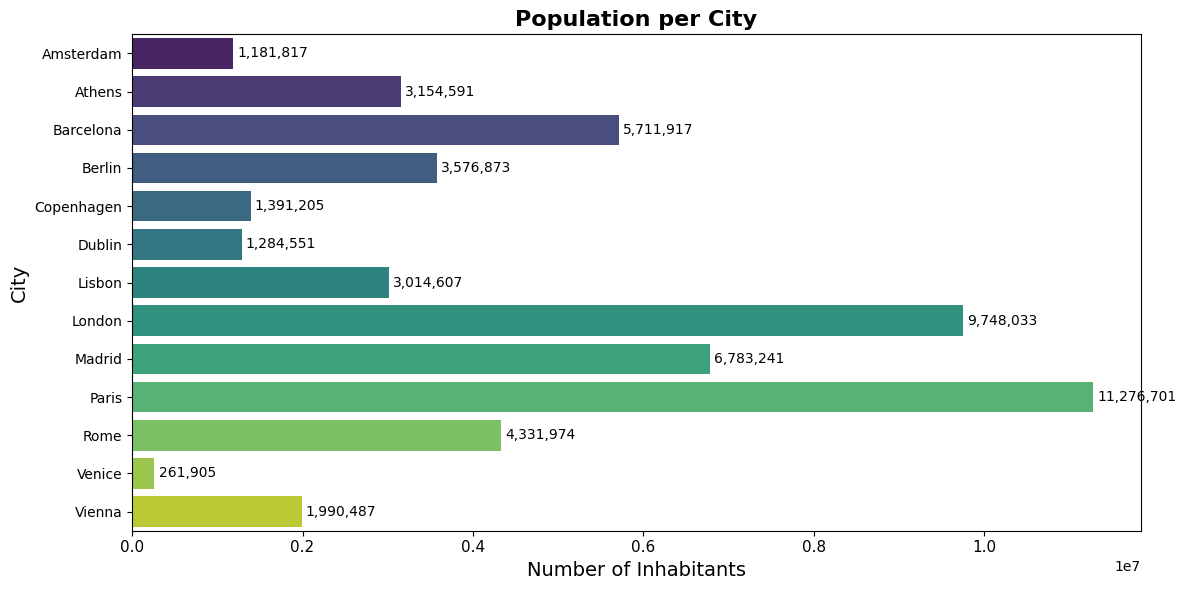

In [ ]:
plt.figure(figsize=(12, 6))

ax = sns.barplot(data=city_population_df, y='city', x='inhabitants', hue='city', palette="viridis", dodge=False, legend=False)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10, padding=3, labels=[f'{int(x):,}' for x in container.datavalues]) # format the labeled numbers

plt.xticks(fontsize=11)
plt.title('Population per City', fontsize=16, weight='bold')
plt.xlabel('Number of Inhabitants', fontsize=14)
plt.ylabel('City', fontsize=14)

plt.tight_layout()
plt.show()

This plot, together with the previous bar chart of listings per city, reveals a strong correlation between population size and the number of Airbnb listings, indicating that cities with larger populations tend to have more listings. However, this isn't always the case; for instance, Dublin stands out as an outlier—despite its substantial population, it has a surprisingly low number of Airbnb listings. Next, let’s examine what the Airbnb density can reveal about this situation.

First, we will calculate the **Airbnb density**, defined as the number of Airbnb listings per 1,000 inhabitants. This can be expressed with the following formula:

$$
\text{Airbnb Density} = \frac{\text{Number of Listings}}{\text{Population}} \times 1000
$$

After calculating the density, we will save the results in a new DataFrame to facilitate easy visualization and analysis.

In [ ]:
density_per_city = listings_per_city.merge(city_population_df, on='city')
density_per_city['density'] = (density_per_city['num_listings'] / density_per_city['inhabitants'] * 1000).round(2)
density_per_city

,city,num_listings,inhabitants,density
0,Amsterdam,11342,1181817,9.60
1,Athens,17112,3154591,5.42
2,Barcelona,24860,5711917,4.35
3,Berlin,15830,3576873,4.43
4,Copenhagen,24927,1391205,17.92
5,Dublin,12196,1284551,9.49
6,Lisbon,28914,3014607,9.59
7,London,129659,9748033,13.30
8,Madrid,35542,6783241,5.24
9,Paris,118804,11276701,10.54


The key step was to merge the two DataFrames we had—listings and inhabitants—using their common column, **city**. This allowed us to consolidate all relevant information, enabling us to apply our formula effectively.

To better understand the relationship between Airbnb listings and population size, it is essential to analyze the Airbnb density for each city.

- A high Airbnb density value suggests that there are numerous listings in relation to the population size.
-A low Airbnb density value indicates that there are relatively few listings compared to the population size.  

Now, let's visualize these results using a bar plot. In this plot, the x-axis will represent the cities, while the y-axis will display their corresponding Airbnb densities. We will summarize the key insights after the visualization.

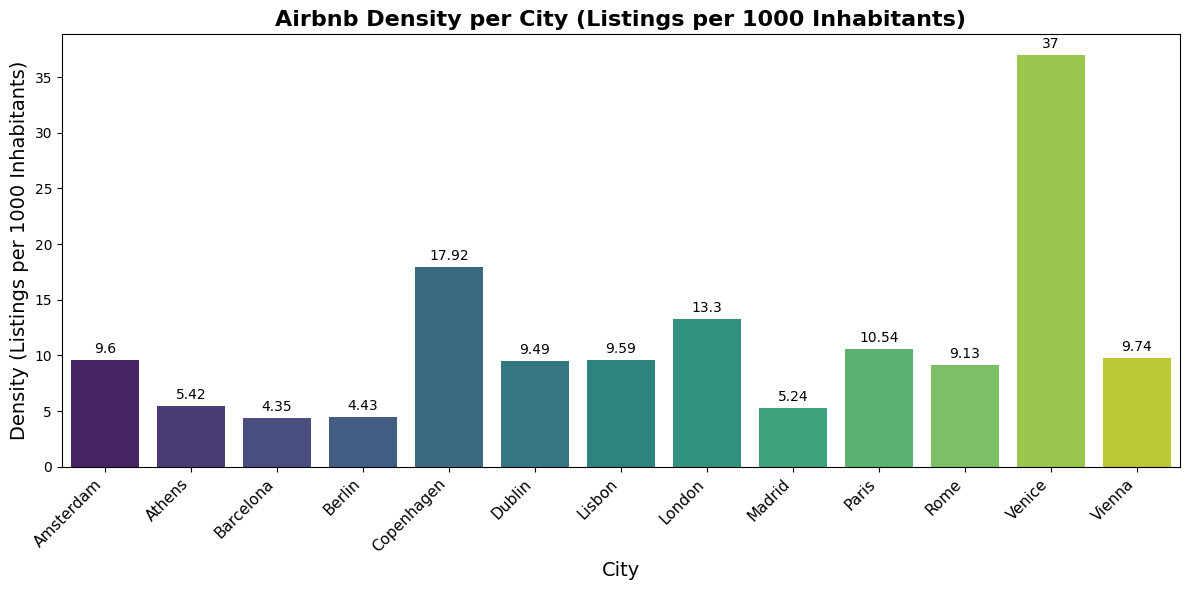

In [ ]:
plt.figure(figsize=(12, 6))

ax = sns.barplot(data=density_per_city, x='city', y='density', palette="viridis", hue='city', dodge=False, legend=False)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10, padding=3)

plt.xticks(rotation=45, ha='right', fontsize=11)

plt.title('Airbnb Density per City (Listings per 1000 Inhabitants)', fontsize=16, weight='bold')
plt.xlabel('City', fontsize=14)
plt.ylabel('Density (Listings per 1000 Inhabitants)', fontsize=14)

plt.tight_layout()
plt.show()


Here are the key insights derived from the analysis:

- **Highest Density**: Venice leads with the highest density of (37.00) listings per 1,000 inhabitants, indicating a robust availability of rental options despite its smaller population size.

- **Lowest Density**: Barcelona records the lowest density at just (4.35) listings per 1,000 inhabitants, reflecting a limited supply of Airbnb listings in comparison to its largely enough population.

- **Notable Densities**: Copenhagen (17.92) demonstrates strong density, suggesting that offers a good range of rental options relative to their populations.

- **Most Listings**: London boasts the highest total number of listings at 96,182, followed closely by Paris with 95,461 listings. Additionally, both cities exhibit large enough densities despite to their larger populations.

## Activity

We are interested in the AirBnB bookings and income per listing for each city. Calculate, for each city, the average number of nights a listing is booked, by assuming that half of the bookings have reviews, and that each booking is for three nights. Use the number of reviews for the last 12 months for each listing. To calculate the income per listing, multiply the price of each listing by the number of nights booked you have calculated for the listing. Then, find the average of the income per listing for each city.

To proceed, we will base the following calculations on two key assumptions:

- **Half of all bookings receive reviews**: This means that the total number of bookings for a listing is twice the number of reviews from the last 12 months.

- **Average booking duration**: Each booking is assumed to be for a fixed duration of 3 nights.

These assumptions will guide our estimations and simplify the calculations going forward.

To begin, we will calculate the total estimated bookings for each listing by using the variable `number_of_reviews_ltm`, which represents the number of reviews received in the last 12 months. Since we assume that only half of all bookings receive reviews, we can estimate the total bookings by multiplying number_of_reviews_ltm by 2:    

$$
\text{total_bookings} = \frac{\text{number_of_reviews_ltm}}{\text{0.5}} =
\text{number_of_reviews_ltm} \times 2
$$

We will then add this result as a new variable in the `listings_df` DataFrame.

In [ ]:
listings_df['total_bookings'] = listings_df['number_of_reviews_ltm'] * 2

The next step is to calculate the total number of nights booked for each listing. Based on our assumption that each booking spans 3 nights, we can determine the total nights booked by multiplying the total bookings by 3:

$$
\text{nights_booked} = \text{total_bookings} \times 3
$$

We will also add this result as a new variable, `nights_booked`, in the `listings_df` DataFrame.

In [ ]:
listings_df['nights_booked'] = listings_df['total_bookings'] * 3

Now, we will calculate the income per listing by multiplying each listing's price per night by the total number of nights booked. This gives us an estimated income for each listing:

$$
\text{income} = \text{price} \times \text{nights_booked}
$$

We will add this result as a new column, `income`, to the `listings_df` DataFrame.

In [ ]:
listings_df['income'] = listings_df['price'] * listings_df['nights_booked']

Let's display the calculated variables in a tabular format by selecting only the relevant columns. We will show the first 10 rows of the DataFrame using the `.head(10)` method, allowing for a clearer understanding  of each variable.

In [ ]:
listings_df[['name', 'number_of_reviews_ltm', 'total_bookings', 'nights_booked', 'price', 'income']].head(10)

,name,number_of_reviews_ltm,total_bookings,nights_booked,price,income
0,Condo in Amsterdam · ★4.90 · 1 bedroom · 2 bed...,51,102,306,69.0,21114.0
1,Townhouse in Amsterdam · ★4.44 · 1 bedroom · 1...,30,60,180,117.0,21060.0
2,Houseboat in Amsterdam · ★4.93 · 1 bedroom · 1...,24,48,144,155.0,22320.0
3,Rental unit in Amsterdam · ★4.87 · 1 bedroom ·...,116,232,696,79.0,54984.0
4,Rental unit in Amsterdam · ★4.81 · 1 bedroom ·...,97,194,582,59.0,34338.0
5,Rental unit in Amsterdam · ★4.72 · 2 bedrooms ...,0,0,0,240.0,0.0
6,Rental unit in Amsterdam · 2 bedrooms · 2 beds...,2,4,12,269.0,3228.0
7,Guest suite in Amsterdam · ★4.93 · 2 bedrooms ...,64,128,384,354.0,135936.0
8,Condo in Amsterdam · ★4.87 · 2 bedrooms · 3 be...,7,14,42,450.0,18900.0
9,Bed and breakfast in Amsterdam · ★4.88 · 1 bed...,70,140,420,124.0,52080.0


As we can see from the table above, there are two main issues to address:

- **Listings with No Reviews**: Some listings do not have any reviews in the last 12 months, which results in zero values for all the calculated columns.

- **NaN Values in the Price Column**: There are listings that contain NaN values in the price column. As a result, the income variable we calculated also returns NaN for these listings.  

Later, we will perform some groupings based on city, so both issues won't significantly impact our results. Listings with no reviews will contribute zero values, which will be included in the totals. Additionally, NaN values in the price column will be ignored during the grouping, preventing them from affecting the overall analysis.

Our final step for this section is to calculate the **average income per listing for each city**. To accomplish this, we will group our DataFrame by `city` using the `.groupby()` method and then apply the mean to the income variable using the `.agg()` function.

In [ ]:
average_income_per_city = listings_df.groupby('city').agg(
    average_income_per_listing=('income', 'mean')
).reset_index()

average_income_per_city['average_income_per_listing'] = average_income_per_city['average_income_per_listing'].round(2)

average_income_per_city

,city,average_income_per_listing
0,Amsterdam,9498.20
1,Athens,6146.43
2,Barcelona,7861.71
3,Berlin,7116.87
4,Copenhagen,31039.00
5,Dublin,8580.64
6,Lisbon,7921.50
7,London,4186.76
8,Madrid,7205.83
9,Paris,5441.93


## Cross-check

Find the total number of bookings and nights spent over the last 12 months period for which you have data, for each of the cities. Then compare your findings with publicly available data. Explain how you sourced the data, the methodology that has been used for their collection, and your assessment of their quality. Discuss any differences from your own results.

Similar to the previous grouping by city, we will create two new aggregations. This time, instead of calculating the mean, we will use the sum function to determine the total number of bookings and the total number of nights booked for each city.

**1) Total Bookings**: We will perform a grouping using the `.groupby()` function and apply the sum aggregation to the `total_bookings` column for each city. This will give us the overall number of bookings made in each location.

In [ ]:
total_bookings_per_city = listings_df.groupby('city').agg(
    total_bookings=('total_bookings', 'sum')
).reset_index()

total_bookings_per_city

,city,total_bookings
0,Amsterdam,191882
1,Athens,371878
2,Barcelona,466402
3,Berlin,253260
4,Copenhagen,213690
5,Dublin,169070
6,Lisbon,729722
7,London,1184596
8,Madrid,743392
9,Paris,1119748


**2) Total Nights Booked**: Similarly, we will create another grouping where we sum the `nights_booked` column for each city. This will provide insights into the total number of nights that listings were booked across different cities.

In [ ]:
total_nights_booked_per_city = listings_df.groupby('city').agg(
    total_nights_booked=('nights_booked', 'sum')
).reset_index()

total_nights_booked_per_city

,city,total_nights_booked
0,Amsterdam,575646
1,Athens,1115634
2,Barcelona,1399206
3,Berlin,759780
4,Copenhagen,641070
5,Dublin,507210
6,Lisbon,2189166
7,London,3553788
8,Madrid,2230176
9,Paris,3359244


Now, it's time to load some data from the internet. Finding a relevant dataset with Airbnb information from the last 12 months for comparison wasn't an easy task due to several challenges. Many datasets available online either led us back to the one we already had, were outdated, or required a paid subscription for access. Some notable sources we explored include:

- [Backlinko](https://backlinko.com/airbnb-stats#average-nights-per-airbnb-booking): Provides up-to-date data, including information for the first quarters of 2024. However, the data is not broken down by city or country, and there are no figures for total bookings or nights booked.
- [Demand Stage](https://www.demandsage.com/airbnb-statistics/): Offers some recent data, but primarily covers information from before 2022. While there is some analysis by region and country, no data on bookings or nights booked is available.
- [Unknown Github Repo](https://github.com/Dorcas27/European-Airbnb-Data-Analysis-Power-BI/blob/main/Airbnb-Data-Analysis-PowerBI/Airbnb%20Dataset-Europe.csv): This dataset includes data for European cities, where total bookings and nights booked can be calculated. However, many cities are missing, and the data’s source and accuracy are unknown.


We could not find an exact dataset for European city-level Airbnb bookings and total nights stayed in 2024, so we adapted publicly available data through a series of assumptions to meet our needs. This method, while not completely accurate, is transparent and can still yield useful insights due to its reliance on current data and logical adjustments. Additionally, it’s worth noting that much of the data from Inside Airbnb itself is also based on certain assumptions and approximations. Ultimately, we decided to use data from [eurostat](https://ec.europa.eu/eurostat/databrowser/view/TOUR_CE_OMR__custom_13688163/default/table?lang=en) due to its recent, comprehensive coverage, making it suitable for our analysis.

**Dataset Overview**  
Our dataset, titled *Short-stay accommodation offered via collaborative economy platforms by months and residence of the guest - experimental statistics*, provides data on bookings (under the tourist indicator **Stays**) and nights spent (under **Nights Spent**) in short-term accommodations across various European countries up until June 2024. This period aligns with data availability for less than half of the cities covered in the Inside Airbnb dataset.

The Eurostat data has been manually downloaded in `.xlsx` format and stored in the `external_data` folder within the drive folder. This is now available in the current workspace under the path `"data/external_data"`. A web scraping attempt was made, but due to the complexity of Eurostat's dynamic webpage, it was not successful in extracting the data. We will continue processing the downloaded .xlsx files instead, with the first file named `bookings_eurostat.xlsx` and the second `nights_eurostat.xlsx`.

In [ ]:
external_data_path = "/content/data/external_data/" # remove /content/ if not in google collab

bookings_eurostat = pd.read_excel(os.path.join(external_data_path, 'bookings_eurostat.xlsx'))
nights_eurostat = pd.read_excel(os.path.join(external_data_path, 'nights_eurostat.xlsx'))

Let's preview the first 30 rows of the dataset using `.head(30)` to understand its structure. Note that both the bookings and nights datasets share the same format, so we will apply the same steps to process them in parallel.

In [ ]:
bookings_eurostat.head(25)

,Data extracted on 09/11/2024 20:22:47 from [ESTAT],Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Dataset:,Short-stay accommodation offered via collabora...,NaN,NaN,NaN
1,Last updated:,03/10/2024 11:00,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,Time frequency,NaN,Annual,NaN,NaN
4,Tourism indicator,NaN,Stays,NaN,NaN
5,Country of residence,NaN,Total,NaN,NaN
6,Unit of measure,NaN,Number,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN
8,TIME,NaN,2023,NaN,2024
9,GEO (Labels),MONTH (Labels),NaN,NaN,NaN


Based on the initial dataframe:

- The first 10 rows contain metadata, so we will drop them.   
- The column titled `"Data extracted on 09/11/2024 19:28:49 from [ESTAT]"` will be renamed to `"country" `as it contains the country names.
- The column named `"Unnamed: 1"` corresponds to the month and will be renamed accordingly.
- The columns `"Unnamed: 2"` and `"Unnamed: 4"` likely represent the total values for the years 2023 and 2024, respectively, and will be renamed appropriately.
- The column `"Unamed: 3"` only contains NaN values and we will drop it.
- Extra: The last 3 rows are redudant.

We'll implement these changes for both datasets in the next step.

In [ ]:
# drop first 10 rows
bookings_eurostat = bookings_eurostat.drop(bookings_eurostat.index[:10])
nights_eurostat = nights_eurostat.drop(nights_eurostat.index[:10])

# rename 'Data extracted on 09/11/2024 20:22:47 from [ESTAT]' column
bookings_eurostat = bookings_eurostat.rename(columns={'Data extracted on 09/11/2024 20:22:47 from [ESTAT]': 'country'})
# rename 'Données extraites le09/11/2024 20:21:43 depuis [ESTAT]' column
nights_eurostat = nights_eurostat.rename(columns={'Données extraites le09/11/2024 20:21:43 depuis [ESTAT]': 'country'})

# rename 'Unamed: 1' column
bookings_eurostat = bookings_eurostat.rename(columns={'Unnamed: 1': 'month'})
nights_eurostat = nights_eurostat.rename(columns={'Unnamed: 1': 'month'})

# rename 'Unamed: 2' column
bookings_eurostat = bookings_eurostat.rename(columns={'Unnamed: 2': '2023'})
nights_eurostat = nights_eurostat.rename(columns={'Unnamed: 2': '2023'})

# rename 'Unamed: 4' column
bookings_eurostat = bookings_eurostat.rename(columns={'Unnamed: 4': '2024'})
nights_eurostat = nights_eurostat.rename(columns={'Unnamed: 4': '2024'})

# drop 'Unamed: 3' column
bookings_eurostat = bookings_eurostat.drop(columns=['Unnamed: 3'])
nights_eurostat = nights_eurostat.drop(columns=['Unnamed: 3'])

# drop last 3 rows
bookings_eurostat = bookings_eurostat.drop(bookings_eurostat.index[-3:])
nights_eurostat = nights_eurostat.drop(nights_eurostat.index[-3:])

bookings_eurostat

,country,month,2023,2024
10,European Union - 27 countries (from 2020),January,2719303,3213966
11,European Union - 27 countries (from 2020),February,3185032,3894102
12,European Union - 27 countries (from 2020),March,3502591,4923742
13,European Union - 27 countries (from 2020),April,5304043,5537725
14,European Union - 27 countries (from 2020),May,5723245,7442832
...,...,...,...,...
389,Switzerland,August,104832,:
390,Switzerland,September,87314,:
391,Switzerland,October,70275,:
392,Switzerland,November,45289,:


Now that the dataset has been cleaned, let's examine the countries covered by our dataset by calling `.unique()` on the "country" column.

In [ ]:
bookings_eurostat['country'].unique()

array(['European Union - 27 countries (from 2020)', 'Belgium', 'Bulgaria',
       'Czechia', 'Denmark', 'Germany', 'Estonia', 'Ireland', 'Greece',
       'Spain', 'France', 'Croatia', 'Italy', 'Cyprus', 'Latvia',
       'Lithuania', 'Luxembourg', 'Hungary', 'Malta', 'Netherlands',
       'Austria', 'Poland', 'Portugal', 'Romania', 'Slovenia', 'Slovakia',
       'Finland', 'Sweden', 'Iceland', 'Liechtenstein', 'Norway',
       'Switzerland'], dtype=object)

Unfortunately, the United Kingdom is not present in the list of countries in the dataset, which means that data for London is not available. As a result, our analysis will not include London.

We will continue by filtering the datasets to retain only the countries relevant to the cities we are interested in. To do this, we will create a `country_city_mapping` that links each country to its respective cities. Specifically, we will filter the dataset by checking if the country of each row is contained in the keys of the mapping using `.isin()`.

In [ ]:
country_city_mapping = {
    'Denmark': ['Copenhagen'],
    'Germany': ['Berlin'],
    'Ireland': ['Dublin'],
    'Italy': ['Rome', 'Venice'],
    'Spain': ['Madrid', 'Barcelona'],
    'Netherlands': ['Amsterdam'],
    'France': ['Paris'],
    'Portugal': ['Lisbon'],
    'Greece': ['Athens'],
    'Austria': ['Vienna']
}

bookings_eurostat = bookings_eurostat[bookings_eurostat['country'].isin(country_city_mapping.keys())]
nights_eurostat = nights_eurostat[nights_eurostat['country'].isin(country_city_mapping.keys())]

Due to the fact that the latest data we have from Eurostat is for June 2024, we will focus on the period from **July 2023 to June 2024**, which corresponds to 12 months. We will filter the datasets for this timeframe and then aggregate the values. Specifically, we will create two new dataframes: one for total bookings (from the bookings dataset) and one for total nights (from the nights dataset). Each new dataframe will have columns for `"country"` and either `"total_bookings"` or `"total_nights"`, summarizing the data for the specified period.

In [ ]:
months = bookings_eurostat['month'].unique()
july_index = np.where(months == 'July')[0][0]

july_end = months[july_index:] # months from july until december (will use 2023)
start_june = months[:-july_index] # months from january until june (will use 2024)

In [ ]:
# calculate total bookings per country for the first half of the period
total_bookings_first_half = bookings_eurostat[bookings_eurostat['month'].isin(july_end)].groupby('country').agg(total_bookings=('2023', 'sum')).reset_index()
# calculate total bookings per country for the second half of the period
total_bookings_second_half = bookings_eurostat[bookings_eurostat['month'].isin(start_june)].groupby('country').agg(total_bookings=('2024', 'sum')).reset_index()

# merge two dataframes on the 'country' column
total_bookings_eurostat = pd.merge(total_bookings_first_half, total_bookings_second_half, on='country', how='outer')
# sum the values horizontally for all the rows except the first one
total_bookings_eurostat['total_bookings'] = total_bookings_eurostat.iloc[:, 1:].sum(axis=1)

total_bookings_eurostat = total_bookings_eurostat[['country', 'total_bookings']]

In [ ]:
# calculate total nights per country for the first half of the period
total_nights_first_half = nights_eurostat[nights_eurostat['month'].isin(july_end)].groupby('country').agg(total_nights=('2023', 'sum')).reset_index()
# calculate total nights per country for the second half of the period
total_nights_second_half = nights_eurostat[nights_eurostat['month'].isin(start_june)].groupby('country').agg(total_nights=('2024', 'sum')).reset_index()

# merge two dataframes on the 'country' column
total_nights_eurostat = pd.merge(total_nights_first_half, total_nights_second_half, on='country', how='outer')
# sum the values horizontally for all the rows except the first one

total_nights_eurostat['total_nights_booked'] = total_nights_eurostat.iloc[:, 1:].sum(axis=1)
total_nights_eurostat = total_nights_eurostat[['country', 'total_nights_booked']]

Here's the logic behind the aggregation:
- We separated the 12 months into two lists: July to December (end of 2023) and January to June (start of 2024).  
- For each list, we used `.groupby('country')` and summed the `2023` column values for the first list and the `2024` column values for the second list.
- We `.merge()` the two dataframes on their common column, country, and then sum the values to create a new column called `total_[value]`.
- Finally we keep only the columns we need.

Let's see what we have achieved so far!

In [ ]:
total_bookings_eurostat

,country,total_bookings
0,Austria,1725741
1,Denmark,594045
2,France,16910060
3,Germany,5502048
4,Greece,3554894
5,Ireland,733947
6,Italy,10950100
7,Netherlands,1003863
8,Portugal,3184048
9,Spain,11268795


In [ ]:
total_nights_eurostat

,country,total_nights_booked
0,Austria,22256077
1,Denmark,6563913
2,France,171084292
3,Germany,53854013
4,Greece,41025329
5,Ireland,6885503
6,Italy,115680063
7,Netherlands,10516817
8,Portugal,41685154
9,Spain,155216362


While this dataframe provides a broad view of the short-term rental market across European countries, it differs significantly from our Inside Airbnb dataset in terms of structure and detail.

To bridge the gap between these datasets and make meaningful comparisons, we propose the following key assumptions:

**1) Estimating City-Level Data from Country Totals**  
The dataset provides information at the country level, while the Inside Airbnb data is city-specific. To estimate city-level bookings and nights for the cities we are studying, we will assume that the distribution of bookings and nights corresponds to each city's share of the country's population. For instance, if Barcelona has approximately 30% of Spain’s population and Madrid has 40%, we will allocate 30% and 40% of Spain's short-term rental bookings and nights, respectively, to these cities in our analysis. This approximation allows us to derive city-specific insights while working within the available data constraints.

Next, we’ll find the population for each country, as we already have population data for each city in the `city_population_df`. We’ll use Python’s `Beautiful Soup` library to scrape this information, as it’s an efficient and replicable way to extract data directly from web sources.

In [ ]:
web_url = 'https://www.worldometers.info/world-population/population-by-country/'

response = requests.get(web_url)
response.raise_for_status()

soup = BeautifulSoup(response.text, 'html.parser')
print(soup.prettify()[8000:8500])

name of the country or dependency for current estimates (live population clock), historical data, and projected figures.
        <br/>
        See also:
        <a href="/world-population/">
         World Population
        </a>
        <br/>
       </p>
      </div>
      <div class="table-responsive" style="font-size:14px; width:100%">
       <table cellspacing="0" class="table table-striped table-bordered" id="example2" width="100%">
        <thead>
         <tr>
          <th>
           #



The process is so simple:

- **Send a request:** Access the webpage with a URL request to retrieve the page’s source HTML.  
- **Initialize BeautifulSoup:** Parse the HTML response using `html.parser` in BeautifulSoup.
- **Verify content:** Print a sample section of the response to confirm data retrieval.

The next step is to isolate the specific part of the response that we need: the population table for each country on the webpage.

To extract the table, we locate it within the parsed HTML by using `.find()` on the `soup` object to search specifically for a `<table>` element.

In [ ]:
table = soup.find('table')
print(table.prettify()[:200])

<table cellspacing="0" class="table table-striped table-bordered" id="example2" width="100%">
 <thead>
  <tr>
   <th>
    #
   </th>
   <th>
    Country (or dependency)
   </th>
   <th>
    Population


Now that we’ve isolated the table, we can improve its readability by converting it from raw HTML `<td>` and `<th>` tags into a **DataFrame**. This will allow us to work with the table data in a much easier and more flexible format.
To achive this, we will:

- Extract the column headers by iterating over the `<th>` tags and using `.get_text()` to retrieve their text.
- For the table rows, iterate over each `<tr>` (skipping the first row, which contains the headers), and retrieve the text from each `<td>` tag to obtain the columns.
- Finally, we will structure this data into a DataFrame for easier manipulation and analysis.

In [ ]:
headers = [header.get_text() for header in table.find_all('th')] # extract headers

rows = []
for row in table.find_all('tr')[1:]:  # skip the header row
    cols = [col.get_text() for col in row.find_all('td')]
    rows.append(cols)

country_populations = pd.DataFrame(rows, columns=headers)
country_populations

,#,Country (or dependency),Population (2024),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,1,India,"1,450,935,791",0.89 %,"12,866,195",488,"2,973,190","-630,830",2.0,28,37 %,17.78 %
1,2,China,"1,419,321,278",-0.23 %,"-3,263,655",151,"9,388,211","-318,992",1.0,40,66 %,17.39 %
2,3,United States,"345,426,571",0.57 %,"1,949,236",38,"9,147,420","1,286,132",1.6,38,82 %,4.23 %
3,4,Indonesia,"283,487,931",0.82 %,"2,297,864",156,"1,811,570","-38,469",2.1,30,59 %,3.47 %
4,5,Pakistan,"251,269,164",1.52 %,"3,764,669",326,"770,880","-1,401,173",3.5,20,34 %,3.08 %
...,...,...,...,...,...,...,...,...,...,...,...,...
229,230,Montserrat,"4,389",-0.70 %,-31,44,100,-7,1.4,42,11 %,0.00 %
230,231,Falkland Islands,"3,470",-0.20 %,-7,0,"12,170",-13,1.7,42,68 %,0.00 %
231,232,Tokelau,"2,506",4.55 %,109,251,10,72,2.6,27,0 %,0.00 %
232,233,Niue,"1,819",0.11 %,2,7,260,10,2.5,36,44 %,0.00 %


We will retain only the first two columns, which contain the country and its population, and filter the data to include only the countries listed in the `country_city_mapping`. The column names will be updated to lowercase, and a new `city` column will be added based on the mapping. To handle countries with multiple cities, we will use the `.explode()` function, which will generate a separate row for each city in the mapping, ensuring that every city-country pair is properly represented in the dataframe.

In [ ]:
country_populations = country_populations[['Country (or dependency)', 'Population (2024)']] # drop irrelevant columns
country_populations = country_populations[country_populations['Country (or dependency)'].isin(country_city_mapping.keys())] # keep countries that are in the mapping
country_populations.rename(columns={'Country (or dependency)': 'country', 'Population (2024)': 'country_population'}, inplace=True) # rename columns
country_populations['city'] = country_populations['country'].map(country_city_mapping) # add city columm
country_populations = country_populations.explode('city')
country_populations

,country,country_population,city
18,Germany,"84,552,242",Berlin
22,France,"66,548,530",Paris
24,Italy,"59,342,867",Rome
24,Italy,"59,342,867",Venice
31,Spain,"47,910,526",Madrid
31,Spain,"47,910,526",Barcelona
70,Netherlands,"18,228,742",Amsterdam
92,Portugal,"10,425,292",Lisbon
94,Greece,"10,047,817",Athens
98,Austria,"9,120,813",Vienna


Before proceeding, we should observe that the values in the `country_population` column contain commas. To inspect their data type, we will use `.dtype` in this column.

In [ ]:
country_populations['country_population'].dtype

dtype('O')

We can see that the `country_population` column is not in **integer** format, which is necessary for calculations. To address this, we will first replace the commas with empty spaces using the `.replace()` function, and then convert the resulting string to an integer using `.astype(int)`.

In [ ]:
country_populations['country_population'] = country_populations['country_population'].str.replace(',', '').astype(int)


Now that we have the populations for both the cities and the countries, the next step is to calculate the percentage of the country's population that resides in each city. This can be done by dividing the population of each city by the total population of the corresponding country and multiplying by 100 to get the percentage. But before the calculation, we will `.merge()` the `country_populations` and `city_inhabitants_df` dataframes on the their common column `'city'` and assign the result to a new DataFrame with the name `population_overview_df`.

In [ ]:
population_overview_df = country_populations.merge(city_population_df, on='city')
population_overview_df['city_population_percentage'] = population_overview_df['inhabitants'] / population_overview_df['country_population'] * 100
population_overview_df

,country,country_population,city,inhabitants,city_population_percentage
0,Germany,84552242,Berlin,3576873,4.230370
1,France,66548530,Paris,11276701,16.945079
2,Italy,59342867,Rome,4331974,7.299907
3,Italy,59342867,Venice,261905,0.441342
4,Spain,47910526,Madrid,6783241,14.158143
5,Spain,47910526,Barcelona,5711917,11.922050
6,Netherlands,18228742,Amsterdam,1181817,6.483261
7,Portugal,10425292,Lisbon,3014607,28.916284
8,Greece,10047817,Athens,3154591,31.395785
9,Austria,9120813,Vienna,1990487,21.823570


Now that we have the percentages calculated, we will proceed to estimate the total bookings by multiplying the `city_population_percentage` with the `total_bookings` from the `total_bookings_eurostat` dataframe. To achieve this, we will first merge the two dataframes on the country field. Then, we’ll apply the calculation and retain only the necessary columns.

In [ ]:
total_bookings_per_city_eurostat = total_bookings_eurostat.merge(population_overview_df, on='country')
total_bookings_per_city_eurostat['total_bookings'] = (total_bookings_per_city_eurostat['total_bookings'] * total_bookings_per_city_eurostat['city_population_percentage'] / 100).astype(int) # round
total_bookings_per_city_eurostat = total_bookings_per_city_eurostat[['city', 'total_bookings']]
total_bookings_per_city_eurostat

,city,total_bookings
0,Vienna,376618
1,Copenhagen,138260
2,Paris,2865423
3,Berlin,232757
4,Athens,1116086
5,Dublin,179408
6,Rome,799347
7,Venice,48327
8,Amsterdam,65083
9,Lisbon,920708


We will repeat the same process to estimate the total nights.

In [ ]:
total_nights_per_city_eurostat = total_nights_eurostat.merge(population_overview_df, on='country')
total_nights_per_city_eurostat['total_nights_booked'] = (total_nights_per_city_eurostat['total_nights_booked'] * total_nights_per_city_eurostat['city_population_percentage'] / 100).astype(int) # round
total_nights_per_city_eurostat = total_nights_per_city_eurostat[['city', 'total_nights_booked']]
total_nights_per_city_eurostat

,city,total_nights_booked
0,Vienna,4857070
1,Copenhagen,1527709
2,Paris,28990368
3,Berlin,2278224
4,Athens,12880223
5,Dublin,1683111
6,Rome,8444536
7,Venice,510544
8,Amsterdam,681832
9,Lisbon,12053797


**2) Isolating Airbnb Bookings from Total Platform Bookings**  
The dataset does not specify the platform where bookings were made, while we are focused specifically on Airbnb data. According to **[AirDNA](https://app.airdna.co/data)** insights, the average distribution of Airbnb bookings across the 13 European cities we're studying is approximately 70%. Using this percentage, we will estimate that 70% of the total bookings and nights spent data in our dataset represent Airbnb usage. This assumption allows us to focus on Airbnb-specific trends within the broader dataset of short-term rental platforms.

In [ ]:
total_bookings_per_city_eurostat['total_bookings'] = (total_bookings_per_city_eurostat['total_bookings'] * 0.7).round()
total_nights_per_city_eurostat['total_nights_booked'] = (total_nights_per_city_eurostat['total_nights_booked'] * 0.7).round()

**3) Aligning Data from Different Timeframes**   
Our Inside Airbnb data provides metrics for most European cities up until September 2024, whereas the external dataset we obtained from the web only includes values up to June 2024. To create consistency between these sources, we will adjust the Inside Airbnb data by estimating values based on Airbnb's booking trends. This means we will reduce Airbnb data slightly for the period between June and September, allowing us to better balance and compare the datasets across the same time period. The adjustment is based on the assumption that bookings and nights follow a uniform distribution, so we will estimate the values for the extra months (June to September) and subtract them accordingly.

In [ ]:
cities_with_more_months = [city for city in cities if city not in ['Athens', 'Berlin', 'Copenhagen']] # cities with extra months of data
EXTRA_MONTHS = 2  # extra months of data
MONTHS_OF_YEAR = 12  # total months in a year

for city in cities_with_more_months:
    bookings_adjustment = int(total_bookings_per_city[total_bookings_per_city['city'] == city]['total_bookings'].iloc[0] * EXTRA_MONTHS / MONTHS_OF_YEAR)
    nights_adjustment = int(total_nights_booked_per_city[total_nights_booked_per_city['city'] == city]['total_nights_booked'].iloc[0] * EXTRA_MONTHS / MONTHS_OF_YEAR)

    total_bookings_per_city.loc[total_bookings_per_city['city'] == city, 'total_bookings'] -= bookings_adjustment
    total_nights_booked_per_city.loc[total_nights_booked_per_city['city'] == city, 'total_nights_booked'] -= nights_adjustment

**4) Focus on Short-Term Rentals Only**   
The dataset exclusively captures short-term accommodation data, while the Inside Airbnb dataset includes both short-term and long-term rentals. While most cities have a significant proportion of short-term rentals and a small percentage of long-term rentals, some cities like Berlin and Barcelona have a high percentage (over 35%) of long-term rentals. Estimating bookings and nights for these long-term rentals is difficult because they are not typically booked in the same way or frequency as short-term rentals, so we will exclude them from the analysis, keeping this factor in mind when making comparisons.

Now that we have `total_bookings_per_city` and `total_nights_per_city` on one side, and `total_bookings_per_city_eurostat` and `total_nights_per_city_eurostat` on the other, it’s time to make some comparisons. Firstly, we will merge the datasets to organize all the total bookings information into a single dataframe called `total_bookings_overview`  and then we will plot the data using a bar chart where each city has two bars: one representing data from the first dataframe and the other from the second dataframe, all in the same plot.

In [ ]:
total_bookings_overview = total_bookings_per_city_eurostat.merge(total_bookings_per_city, on='city')
total_bookings_overview.columns = ['city', 'total_bookings_eurostat', 'total_bookings_inside_airbnb']
total_bookings_overview

,city,total_bookings_eurostat,total_bookings_inside_airbnb
0,Vienna,263633.0,318390
1,Copenhagen,96782.0,213690
2,Paris,2005796.0,933124
3,Berlin,162930.0,253260
4,Athens,781260.0,371878
5,Dublin,125586.0,140892
6,Rome,559543.0,811522
7,Venice,33829.0,279247
8,Amsterdam,45558.0,159902
9,Lisbon,644496.0,608102


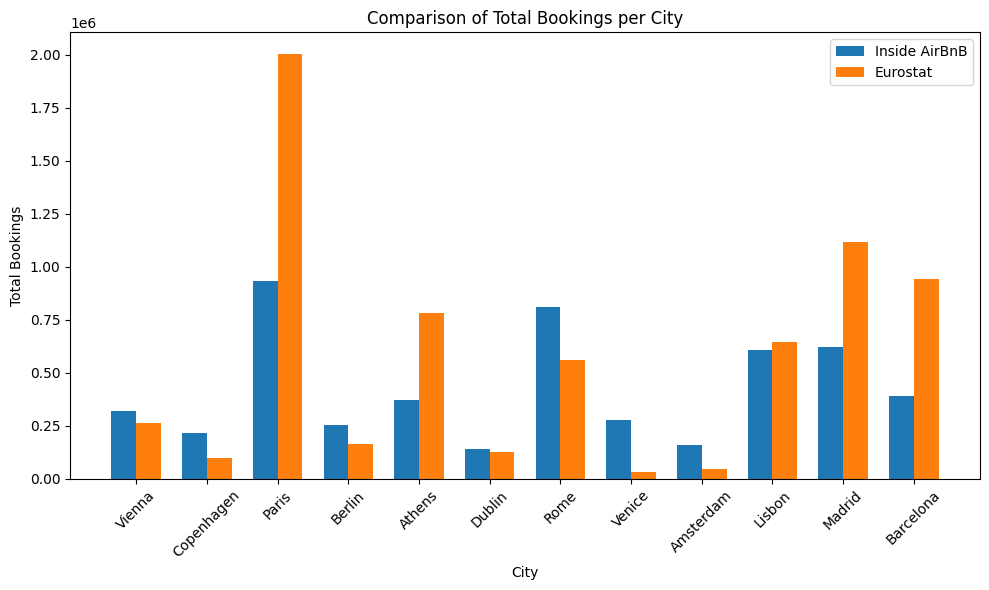

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35

# positions of the bars
index = range(len(total_bookings_overview))

# bar1 plots the total bookings of the inside airbnb data
bar1 = ax.bar(index, total_bookings_overview['total_bookings_inside_airbnb'], bar_width, label='Inside AirBnB')
# bar 2 plots the total bookings of the eurostat data
bar2 = ax.bar([p + bar_width for p in index], total_bookings_overview['total_bookings_eurostat'], bar_width, label='Eurostat')

ax.set_xlabel('City')
ax.set_ylabel('Total Bookings')
ax.set_title('Comparison of Total Bookings per City')

# add cities on the x-axis
ax.set_xticks([p + bar_width/2 for p in index])
ax.set_xticklabels(total_bookings_overview['city'], rotation=45)

ax.legend()

plt.tight_layout()
plt.show()

**Reminder**
- It's natural that the results vary since both datasets follow different assumptions in how they calculate the plotted values.
- Inside Airbnb relies on the number of reviews in the last 12 months to estimate total bookings, which might not perfectly reflect actual bookings, as not everyone who stays at an Airbnb leaves a review.
- Eurostat uses a more generalized approach, estimating bookings based on the percentage of the city's population in relation to the country.

**Insights**
- `Close Results`: Cities like *Vienna*, *Berlin*, *Dublin*, and *Lisbon* show very similar results across both datasets. This suggests that both datasets may be aligned for cities where bookings closely correlate with the population share.
- `Moderate Differences`: For cities like *Copenhagen* and *Amsterdam* there are noticeable but not drastic differences between datasets.
- `Significant Differences`: *Rome* and *Venice* show notable variations, with Inside Airbnb reporting higher values. This could indicate that people in these cities leave more reviews or that the number of Airbnb listings doesn't correlate with the population share.
- `Outliers`: *Barcelona*, *Madrid* and *Paris* exhibit large differences. Paris’s Eurostat data is significantly higher, likely due to Paris's large population share within France, which increases its estimated total bookings in the Eurostat data.

**Conclusion**  
The estimates from Eurostat and Inside Airbnb are fairly close for most cities, particularly for the first four (Vienna, Berlin, Dublin, Lisbon), but the variations increase in cities like Rome, Madrid, Barcelona, and Paris.

We will perform a similar merge for the total nights booked, ensuring that both data sources are combined into a single dataframe called `total_nights_booked_overview` and replicate the previous bar chart, but this time comparing the total nights booked data for each city from both datasets.

In [ ]:
total_nights_booked_overview = total_nights_per_city_eurostat.merge(total_nights_booked_per_city, on='city')
total_nights_booked_overview.columns = ['city', 'total_nights_booked_eurostat', 'total_nights_booked_inside_airbnb']
total_nights_booked_overview

,city,total_nights_booked_eurostat,total_nights_booked_inside_airbnb
0,Vienna,3399949.0,955170
1,Copenhagen,1069396.0,641070
2,Paris,20293258.0,2799370
3,Berlin,1594757.0,759780
4,Athens,9016156.0,1115634
5,Dublin,1178178.0,422675
6,Rome,5911175.0,2434565
7,Venice,357381.0,837740
8,Amsterdam,477282.0,479705
9,Lisbon,8437658.0,1824305


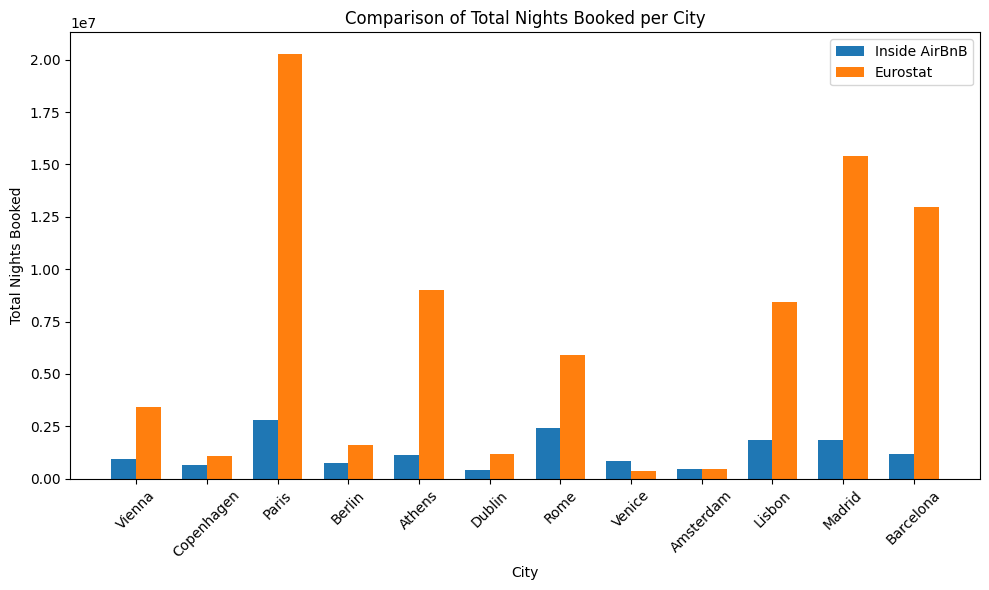

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35

# positions of the bars
index = range(len(total_nights_booked_overview))

# bar1 plots the total nights booked of the inside airbnb data
bar1 = ax.bar(index, total_nights_booked_overview['total_nights_booked_inside_airbnb'], bar_width, label='Inside AirBnB')
# bar2 plots the total nights booked of the eurostat data
bar2 = ax.bar([p + bar_width for p in index], total_nights_booked_overview['total_nights_booked_eurostat'], bar_width, label='Eurostat')

ax.set_xlabel('City')
ax.set_ylabel('Total Nights Booked')
ax.set_title('Comparison of Total Nights Booked per City')

# add cities on the x-axis
ax.set_xticks([p + bar_width/2 for p in index])
ax.set_xticklabels(total_nights_booked_overview['city'], rotation=45)

ax.legend()

plt.tight_layout()
plt.show()

**Reminder**   
- Inside Airbnb calculates total nights booked by multiplying total bookings by 3, assuming each booking spans 3 nights.
- Eurostat data calculates city estimates based on national population distributions, using similar assumptions as in previous analyses.

**Insights**
- `Close Comparisons`: For 5 out of 12 cities, the values are very similar, alike the initial differences in total bookings. The assumptions in both datasets seem to align worse here.
- `Moderate Differences`: In *Vienna* and *Rome*, Eurostat's totals are slightly higher, suggesting its population scaling may cause small increases across many cities.
- `Significant Outliers`: *Paris*, the two largest Spanish cities, as well as "Athens" and "Lisbon" show large differences, with Eurostat values notably higher. This could indicate that population-based assumptions are inflating Eurostat's numbers in highly populated areas.

**Conclusion**   
The results in this plot were notably less closer, with more cities showing similar values between datasets but with bigger differences for many cities. This indicates that both methods may align better for total bookings than for nights booked. Eurostat’s population-based scaling does tend to produce higher estimates, especially for dense cities, while Inside Airbnb’s simpler assumptions may underrepresent totals for larger cities.

## Visualisation

Check the visualisations at the right of <https://insideairbnb.com/athens/>. Replicate these visualisations. Make the selection interactive, i.e., the user should be able to select a city from a dropdown box and see the corresponding visualisations. You can use any visualisation library. A good visualisation library that we did not have time to explore in the lectures but is worth your attention and comes with interactive features is [Vega-Altair]( https://altair-viz.github.io/user_guide/interactions.html).

Each city's InsideAirbnb page includes six visualizations on the right side, highlighting key data insights. In the following cells, we will explore each visualization in detail. For each, we'll first explain its purpose, then create two flexible functions to replicate it for any city. The first function will handle data processing `(process_[plot_name]_data)`, while the second will manage styling and plotting `([plot_name]_plot)`.


Each *processing function* will take `listings_df` as an argument, along with a hyperparameter (e.g., a `threshold`) used for filtering. It will operate only on the listings for the given city and perform the necessary calculations to generate the targeted plot. The *plotting function* will call the processing function to retrieve the required data and will also receive the `city` parameter for the plot titles. This approach ensures we can consistently and easily reproduce the visualizations for different cities and their unique data characteristics.

**Note**: A more detailed explanation of the filtering processes will be provided, while the plotting will be briefly covered, as the code itself contains extensive comments.

**Now, let's analyze the visualizations!**

**1) Room Type**  
 A horizontal bar plot displaying the distribution of listings by room type. The horizontal axis represents the number of listings, while the vertical axis categorizes room types, which can include "*Entire home/apartment*", "*Private room*", "*Shared room*" and, more recently, "*Hotel room*". Each bar displays the total count at its end, and the same information, along with the percentages, is also shown in the statistics section next to the plot.

In [ ]:
def process_room_type_data(df):
    all_room_types = ['Entire home/apt', 'Private room', 'Shared room', 'Hotel room']

    room_type_counts = df['room_type'].value_counts()

    room_type_df = pd.DataFrame(room_type_counts).reset_index()
    room_type_df.columns = ['room_type', 'count']

    for room_type in all_room_types:
        if room_type not in room_type_df['room_type'].values:
            missing_row = pd.DataFrame({'room_type': [room_type], 'count': [0]})
            room_type_df = pd.concat([room_type_df, missing_row], ignore_index=True)

    room_type_df = room_type_df.set_index('room_type').reindex(all_room_types).reset_index()

    total_listings = room_type_df['count'].sum()
    room_type_df['percentage'] = (room_type_df['count'] / total_listings * 100).round(1)

    return room_type_df, total_listings

Here’s a breakdown of the `process_room_type_data` function:

- We start by applying `.value_counts()` on the `room_type` column to count the number of listings in each room type category (like "Entire home/apartment" or "Private room").

- We then ensure that all predefined room type categories are included in the DataFrame, even those with 0 listings, by adding them with a count of 0.

- To calculate the percentages, each count is divided by the total number of listings, and the result is rounded to one decimal place.

In [ ]:
def room_type_plot(df, city):
    room_type_df, total_listings = process_room_type_data(df)

    # custom color mapping for each room type
    room_type_colors = {
        'Entire home/apt': 'red',
        'Private room': 'green',
        'Shared room': 'blue',
        'Hotel room': 'purple'
    }

    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")

    # generate color palette based on the mapping
    palette = [room_type_colors.get(rt, 'gray') for rt in room_type_df['room_type']]

    # create bar plot with room types and counts
    ax = sns.barplot(data=room_type_df, y='room_type', x='count', palette=palette, hue='room_type', dodge=False, legend=False)

    # add count text at the end of each bar
    for index, row in room_type_df.iterrows():
        if row['count'] == 0: continue  # skip empty room types
        ax.text(row['count'], index, f"{row['count']:,}", color="black", va="center")

    plt.title(f'Room Type in {city}', fontsize=16, weight='bold')
    plt.xlabel('Number of Listings', fontsize=14)
    plt.ylabel('Room Type', fontsize=14)
    plt.tight_layout()

    room_types = ['entire homes/apartments', 'private rooms', 'shared rooms', 'hotel rooms']

    # main statistic: percentage of entire homes/apartments
    entire_home_text = f"{room_type_df.loc[room_type_df['room_type'] == 'Entire home/apt', 'count'].sum() / total_listings * 100:.1f}%"

    # text for all room type statistics
    stats_text = "entire homes/apartments\n\n" + "\n".join([
        f"{row['count']:,} ({row['percentage']}%)\n {room_types[i]}\n"
        for i, row in room_type_df.iterrows()
    ])

    # custom fonts for the statistics texts
    entire_home_font = {'fontsize': 20, 'fontweight': 'bold', 'color': 'black'}
    stats_font = {'fontsize': 10, 'fontweight': 'normal', 'color': 'black'}

    # place the entire home/apartment percentage text
    plt.gca().text(
        1.05, 0.7, entire_home_text,
        transform=plt.gca().transAxes,
        verticalalignment='center',
        fontdict=entire_home_font
    )

    # place the detailed statistics text
    plt.gca().text(
        1.05, 0.43, stats_text,
        transform=plt.gca().transAxes,
        verticalalignment='center',
        fontdict=stats_font
    )

    fig = plt.gcf()
    return fig

**2) Activity**   
This visualization is a bar plot that illustrates the occupancy distribution for listings in a given city over the past 12 months. The x-axis categorizes the number of nights booked into ranges (e.g., "1-30," "31-60"), while the y-axis shows the count of listings within each occupancy range. In the right side of the plot, the statistics section provides a summary of key stats: the average price per night, the average nights booked, and the average income per listing.

In [ ]:
def process_activity_data(df, average_length_of_stay=3, review_rate=0.5):
    df = df.copy()

    df['estimated_bookings'] = df['number_of_reviews_ltm'] * (1 / review_rate)

    df['length_of_stay_per_booking'] = df.apply(
        lambda row: max(row['minimum_nights'], average_length_of_stay), axis=1
    )

    df['nights_booked'] = df['estimated_bookings'] * df['length_of_stay_per_booking']

    max_nights = 365 * 0.70
    df['nights_booked'] = df['nights_booked'].clip(upper=max_nights)

    df['price'] = df['price'].round()
    df['nights_booked'] = df['nights_booked'].round()

    df['income'] = df['price'] * df['nights_booked']

    avg_income = round(df['income'].sum() / len(df['price']))
    price_per_night = round(df['price'].sum() / len(df['nights_booked']))
    avg_nights_booked = round(df['nights_booked'].sum() / len(df['nights_booked']))

    ranges = [
        (0, 0), (1, 29), (30, 59), (60, 89), (90, 119),
        (120, 149), (150, 179), (180, 209), (210, 239), (241, float('inf'))
    ]
    range_labels = [
        "0", "1-30", "31-60", "61-90", "91-120",
        "121-150", "151-180", "181-210", "211-240", "241-255+"
    ]

    counts = [df[df['nights_booked'].between(r[0], r[1])].shape[0] for r in ranges]
    plot_data = pd.DataFrame({'Range': range_labels, 'Count': counts})

    return plot_data, avg_income, price_per_night, avg_nights_booked


Here's a breakdown of the `process_activity_data` function:

- It starts by calculating the `estimated bookings` for each listing based on the number of reviews from the last 12 months, assuming a default review rate (e.g., 50%) to estimate the number of bookings.

- It then determines the `length of stay per booking` by selecting the greater of the listing's minimum nights or a default city-wide average length of stay (e.g., 3 nights), and calculates the total `nights booked` for each listing.

- The maximum number of nights booked is capped at 70% of the total days in a year (365 days), and the `income` is computed by multiplying the price per night by the nights booked.

- Average values, including `avg_income`, `price_per_night`, and `avg_nights_booked`, are computed by summing each listing's data and dividing by the number of listings.

- The listings are grouped into predefined occupancy ranges (e.g., "1-30 nights", "31-60 nights"), and the number of listings in each range is counted.

**Note**: Many of the values used in this function (such as the review rate of 50%, the average length of stay of 3 nights, and the capping at 70% of the year) are based on the assumptions found in the Inside Airbnb website.

In [ ]:
def activity_plot(df, city, average_length_of_stay=3, review_rate=0.5):
    plot_data, avg_income, price_per_night, avg_nights_booked = process_activity_data(df, average_length_of_stay, review_rate)

    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")

    # create barplot with occupancy and count
    sns.barplot(data=plot_data, x='Range', y='Count', dodge=False, legend=False)

    # add count label at the top of each bar
    for index, row in plot_data.iterrows():
        if row['Count'] == 0: continue # skip empty activity
        plt.text(index, row['Count'], f"{row['Count']:,}", ha='center', va='bottom', fontsize=10)

    plt.title(f'Activity in {city}', fontsize=16, weight='bold')
    plt.xlabel('Occupancy (last 12 months)', fontsize=14)
    plt.ylabel('Number of Listings', fontsize=14)

    # main statistic: average nights booked
    avg_nights_booked_text = f"{avg_nights_booked}"

    # text for all activity statistics
    stats_text = (
        f"average nights booked\n\n"
        f"€{price_per_night:,}\nprice/night:\n\n"
        f"€{avg_income:,}\naverage income"
    )

    # custom fonts for the statistics texts
    avg_nights_booked_font = {'fontsize': 20, 'fontweight': 'bold', 'color': 'black'}
    stats_font = {'fontsize': 10, 'fontweight': 'normal', 'color': 'black'}

    # place the average nights booked text
    plt.gca().text(
        1.05, 0.60, avg_nights_booked_text,
        transform=plt.gca().transAxes,
        verticalalignment='center',
        fontdict=avg_nights_booked_font
    )

    # place the detailed statistics text
    plt.gca().text(
        1.05, 0.46, stats_text,
        transform=plt.gca().transAxes,
        verticalalignment='center',
        fontdict=stats_font
    )

    plt.tight_layout()

    fig = plt.gcf()
    return fig

**3) Licenses**  
This pie chart shows the distribution of listings by licensing status, categorized as licensed, unlicensed, falsely claiming exemptions, or pending approval. Each segment represents the count of listings in one category, with detailed statistics on the right displaying both the count and percentage for each.

In [ ]:
def process_license_data(df):
    license_mapping = {
        'exempt': 'exempt',
        'lease': 'exempt',
        'pending': 'pending',
        'unlicensed': 'unlicensed'
    }

    df = df.copy()

    df['license'] = df['license'].fillna('unlicensed')

    df['license_category'] = df['license'].apply(
      lambda x: next((value for key, value in license_mapping.items() if key in x.lower()), 'licensed')
    )

    license_counts = df['license_category'].value_counts()
    total_listings = license_counts.sum()

    return license_counts, total_listings

Here’s a breakdown of the `process_license_data` function:

- First, we replace all NaN values in the license field with "unlicensed" as per the assumptions used by Inside Airbnb.

- We then filter the DataFrame and categorize each listing's license status into four categories—"*licensed*", "*unlicensed*", "*exempt*", and "*pending*". This is done by checking each license entry against keywords from `license_mapping`, which assigns the appropriate category based on whether the keyword is found in the license text.

- Finally, we calculate the number of listings in each license category using `.value_counts()` and determine the total number of listings.

In [ ]:
def licenses_plot(df, city):
    license_counts, total = process_license_data(df)

    # colors for the pie chart slices
    colors = plt.cm.Paired.colors

    formatted_labels = [f"{count:,}" for count in license_counts] # add commas to labels

    plt.figure(figsize=(10, 6))

    plt.pie(
        license_counts,
        labels=formatted_labels,
        startangle=140,
        colors=colors,
        wedgeprops=dict(width=0.3)
    )

    legend_labels = [
        "unlicensed",
        "licensed",
        "exempt",
        "pending"
    ]

    plt.legend(
        legend_labels,
        loc='center', # position the legend inside the pie chart
        bbox_to_anchor=(0.5, 0.5),
        fontsize=10,
        frameon=False
    )

    # main statistic: percentage of ulicensed listings
    unlicensed_text = f"{license_counts.get('unlicensed', 0) / total * 100:.1f}%"


    # text for all license category statistics
    stats_text = "unlicensed\n\n" + "\n".join([
        f"{license_counts.get(label, 0):,} ({license_counts.get(label, 0) / total * 100:.1f}%)\n{label}\n"
        for label in legend_labels
    ])

    # custom fonts for the statistics texts
    unlicensed_font_percentage = {'fontsize': 20, 'fontweight': 'bold', 'color': 'black'}
    stats_font = {'fontsize': 10, 'fontweight': 'normal', 'color': 'black'}


    # place the ulicensed percentage text
    plt.gca().text(
        0.85, 0.70, unlicensed_text,
        transform=plt.gca().transAxes,
        verticalalignment='center',
        fontdict=unlicensed_font_percentage
    )

    # place the detailed statistics text
    plt.gca().text(
        0.85, 0.42, stats_text,
        transform=plt.gca().transAxes,
        verticalalignment='center',
        fontdict=stats_font
    )

    plt.title(f'Licenses in {city}', fontsize=16, weight='bold')
    plt.axis('equal')

    fig = plt.gcf()
    return fig

Here’s a breakdown of the `licenses_plot` function:
- We begin by filtering the DataFrame for the specified city and categorizing each listing's license status into four categories: "*licensed*", "*unlicensed*", "*exempt*", and "*pending*". We first assign "unlicensed" to all NaN values. Then, we apply the `license_mapping` to categorize the licenses based on their names, such as "exempt" and "pending," while all other entries are categorized as "licensed."

- Next, we count the number of listings in each license category using `.value_counts()` and prepare a DataFrame to hold these counts.

- Finally, we create a pie chart to visualize the distribution of license categories, displaying both the count and percentage of listings for each category, along with a legend using `.legend()` for context.

**4) Short-Term Rentals**  
This visualization is a straightforward bar plot where the horizontal axis represents the minimum number of nights required for each listing, while the vertical axis shows the number of listings corresponding to each minimum night value. A threshold is established to categorize listings into *short-term* and *long-term* rentals: listings with a minimum stay of fewer than 30 nights are classified as short-term, while those with a minimum of 30 nights or more are considered long-term. The plot also displays the total count and percentage of both short-term and long-term listings, providing a clear overview of the rental landscape.

In [ ]:
def process_short_term_rentals_data(df, STR_THRESHOLD=30):
    total_listings = df.shape[0]

    min_nights_counts = (
        df['minimum_nights']
        .value_counts()
        .reindex(np.arange(1, df['minimum_nights'].max() + 1), fill_value=0)
        .reset_index()
    )
    min_nights_counts.columns = ['min_nights', 'count']

    min_nights_counts['is_short_term'] = np.where(
        min_nights_counts['min_nights'] < STR_THRESHOLD, 'short-term', 'long-term'
    )
    min_nights_counts['min_nights'] = np.where(
        min_nights_counts['min_nights'] >= 35, '35+', min_nights_counts['min_nights'].astype(str)
    )

    grouped_counts = min_nights_counts.groupby(['min_nights', 'is_short_term'], as_index=False).agg(count=('count', 'sum'))

    count_35_plus = df[df['minimum_nights'] > 35].shape[0]
    if '35+' not in grouped_counts['min_nights'].values:
        grouped_counts = pd.concat([grouped_counts, pd.DataFrame({'min_nights': ['35+'], 'count': [count_35_plus], 'is_short_term': ['long-term']})], ignore_index=True)
    else:
        grouped_counts.loc[grouped_counts['min_nights'] == '35+', 'count'] = count_35_plus

    grouped_counts['min_nights'] = pd.Categorical(
        grouped_counts['min_nights'],
        categories=np.concatenate((np.arange(1, 35), ['35+'])).astype(str).tolist(),
        ordered=True
    )
    grouped_counts = grouped_counts.sort_values('min_nights')
    grouped_counts['percentage'] = (grouped_counts['count'] / grouped_counts['count'].sum() * 100).round(1)

    short_term_count = grouped_counts[grouped_counts['is_short_term'] == 'short-term']['count'].sum()
    long_term_count = grouped_counts[grouped_counts['is_short_term'] == 'long-term']['count'].sum()

    short_term_percentage = (short_term_count / total_listings * 100).round(1)
    long_term_percentage = (long_term_count / total_listings * 100).round(1)

    return grouped_counts, short_term_percentage, long_term_percentage, short_term_count, long_term_count, total_listings

Here's is a breakdown of the `process_short_term_rentals_data` function:
- We begin by calculating the frequency of each minimum_nights value in the data using `.value_counts()` on the `minimum_nights` column. This count is reset into a new DataFrame, ensuring missing values are filled with zero, so all minimum night values up to the maximum are represented.  
- Each minimum night value is classified as either `"short-term"` if it’s below the threshold or `"long-term"` if it’s at or above the `STR_THRESHOLD`. Values greater than 35 are grouped into a single "35+" category.

- For listings with minimum nights above 35, we sum these into the "35+" category and update the `grouped_counts` DataFrame to include this group accurately.

- To control the plot’s display order, we use `pd.Categorical` to set min_nights as an ordered category from 1 to 35+ and then `.sort()` by min_nights to ensure correct order.

- Lastly, we calculate the counts and percentages of short- and long-term rentals by summing each category and dividing by the total number of listings.

In [ ]:
def short_term_rentals_plot(df, city, STR_THRESHOLD=30):
    grouped_counts, short_term_percentage, long_term_percentage, short_term_count, long_term_count, total_listings = process_short_term_rentals_data(df, STR_THRESHOLD)

    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")

    # bar plot with minimun nights and count
    ax = sns.barplot(data=grouped_counts, x='min_nights', y='count', hue='is_short_term', palette="viridis")

    # dashed line indicating the threshold that classifies a rental as short-term
    plt.axvline(x=STR_THRESHOLD - 1.5, color='black', linestyle='--', linewidth=1, label='STR Threshold')

    # add count label at the top of each bar
    for index, row in grouped_counts.iterrows():
        if row['count'] == 0: continue # skip empty minimum nights
        ax.text(
            x=row['min_nights'],
            y=row['count'],
            s=f"{row['count']:,}",
            color="black",
            ha="center",
            fontsize=10,
        )

    plt.legend(title="Rental Category", loc='upper center', bbox_to_anchor=(1.2, 1))
    plt.title(f'Short-Term Rentals in {city}', fontsize=16, weight='bold')
    plt.xlabel('Minimum Nights', fontsize=14)
    plt.ylabel('Number of Listings', fontsize=14)

    # main statistic: short-term rentals
    short_term_rentals_text = f"{short_term_percentage}%"

    # text for all rental category statistics
    stats_text = ('short-term rentals\n\n'
        f"{short_term_count:,} ({short_term_percentage}%)\nshort-term rentals\n\n"
        f"{long_term_count:,} ({long_term_percentage}%)\nlong-term rentals\n"
    )

    # custom fonts for the statistics text
    short_term_rentals_font = {'fontsize': 20, 'fontweight': 'bold', 'color': 'black'}
    stats_font = {'fontsize': 10, 'fontweight': 'normal', 'color': 'black'}

    # place short-term rentals statistics text
    plt.gca().text(
        1.12, 0.60, short_term_rentals_text,
        transform=plt.gca().transAxes,
        verticalalignment='center',
        fontdict=short_term_rentals_font
    )

    # place the detailed statistics text
    plt.gca().text(
        1.12, 0.43, stats_text,
        transform=plt.gca().transAxes,
        verticalalignment='center',
        fontdict=stats_font
    )

    plt.tight_layout()

    fig = plt.gcf()
    return fig

**5) Listings per Host**  
This visualization is a simple bar plot, where the horizontal axis represents the number of listings owned by a single host, and the vertical axis indicates the count of listings associated with hosts having that specific number of listings. For hosts with more than 10 listings, the count is categorized as "10+" to simplify the display. The plot also shows both the counts and percentages of listings for each host category.

In [ ]:
def process_listings_per_host_data(df, STR_THRESHOLD=10):
    total_listings = df.shape[0]

    listings_count = df['host_id'].value_counts().reset_index()
    listings_count.columns = ['host_id', 'num_listings']

    listings_count['listing_category'] = np.where(listings_count['num_listings'] == 1, 'single listings', 'multi-listings')

    count_10_plus = listings_count[listings_count['num_listings'] >= STR_THRESHOLD]['num_listings'].sum()
    listings_count_without_10_plus = listings_count[listings_count['num_listings'] < STR_THRESHOLD]

    grouped_counts = listings_count_without_10_plus.groupby(['num_listings', 'listing_category']).agg(sum=('num_listings', 'sum')).reset_index()
    grouped_counts = pd.concat([
        grouped_counts,
        pd.DataFrame({'num_listings': [f"{STR_THRESHOLD}+"], 'sum': [count_10_plus], 'listing_category': ['multi-listings']})
    ], ignore_index=True)

    multi_listing_count = listings_count[listings_count['listing_category'] == 'multi-listings']['num_listings'].sum()
    single_listing_count = listings_count[listings_count['listing_category'] == 'single listings']['num_listings'].sum()

    multi_listing_percentage = (multi_listing_count / total_listings * 100).round(1)
    single_listing_percentage = (single_listing_count / total_listings * 100).round(1)

    return grouped_counts, single_listing_count, single_listing_percentage, multi_listing_count, multi_listing_percentage, total_listings

Here's a breakdown of the `process_listings_per_host_data` function:
- We begin by counting the number of listings each host has, using .`value_counts()` on the host_id column.
- This count data is placed in a new DataFrame, where hosts are categorized by their listing numbers: hosts with a single listing are labeled as `"single listings"`, while those with multiple listings are labeled as `"multi-listings"`.
- Next, we identify hosts with 10 or more listings, grouping them into a “10+” category to create a cleaner label range from 1 to “10+”. We also calculate the total listings owned by these high-volume hosts.
- Using `.groupby()`, we sum the listing counts for hosts with the same number of listings, creating a DataFrame with `num_listings` (1-9) as the count of listings per host and `sum` as the total number of listings in each category.
- We then append the “10+” category to this DataFrame by using `.concat()`, integrating it with the counts calculated previously.
- Finally, we calculate statistics for single and multi-listings, including counts and percentages, by summing each category and dividing by the total number of listings.

In [ ]:
def listings_per_host_plot(df, city, STR_THRESHOLD=10):
    grouped_counts, single_listing_count, single_listing_percentage, multi_listing_count, multi_listing_percentage, total_listings = process_listings_per_host_data(df, STR_THRESHOLD)

    # custom color mapping for each type of listing
    palette = {"single listings": "lightblue", "multi-listings": "mediumseagreen"}

    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")

    # bar plot with number and their sum
    ax = sns.barplot(data=grouped_counts, x='num_listings', y='sum', hue='listing_category', palette=palette)

    # add count label at the top of each bar
    for index, row in grouped_counts.iterrows():
        if row['sum'] == 0: continue # skip number of listings with 0 value
        ax.text(
            x=index,
            y=row['sum'],
            s=f"{row['sum']:,}",
            color="black",
            ha="center",
            fontsize=10,
        )

    plt.title(f'Listings per Host in {city}', fontsize=16, weight='bold')
    plt.xlabel('Number of Listings', fontsize=14)
    plt.ylabel('Number of Hosts', fontsize=14)

    # main statistic: multi-listings
    multi_listings_text = f"{multi_listing_percentage}%"

    # text for all listing categories
    stats_text = ("multi-listings\n\n"
        f"{single_listing_count:,} ({single_listing_percentage}%)\n"
        f"single listings\n\n"
        f"{multi_listing_count:,} ({multi_listing_percentage}%)\n"
        f"multi-listings"
    )

    # custom fonts for the statistics text
    stats_font = {'fontsize': 10, 'fontweight': 'normal', 'color': 'black'}
    multi_listings_font = {'fontsize': 20, 'fontweight': 'bold', 'color': 'black'}

    # place the multi-listings statistic
    plt.gca().text(
        1.12, 0.58, multi_listings_text,
        transform=plt.gca().transAxes,
        verticalalignment='center',
        fontdict=multi_listings_font
    )

    # place the detailed statistics text
    plt.gca().text(
        1.135, 0.43, stats_text,
        transform=plt.gca().transAxes,
        verticalalignment='center',
        fontdict=stats_font
    )

    plt.legend(title="Listing Category", loc='upper center', bbox_to_anchor=(1.2, 1))
    plt.tight_layout()

    fig = plt.gcf()
    return fig

**6) Top Hosts**  
This DataFrame, while not a traditional visualization, displays the top 50 hosts ranked by the number of listings they own. For better readability, it’s divided into two tables, each with 25 rows. Each table includes six columns: one for the host's name, four for the total listings under each of the four room type categories (Entire home/apt, Private room, Shared room, and Hotel room), and one column indicating the overall total listings owned by each host.

In [ ]:
def process_top_hosts_data(df):
    room_types = ['Entire home/apt', 'Private room', 'Shared room', 'Hotel room']

    top_hosts_df = (
        df.groupby(['host_id', 'host_name'])
        .size()
        .reset_index(name='count')
        .sort_values(by=['count', 'host_name'], ascending=[False, True])
        .head(50)
    )

    top_hosts_ids = top_hosts_df['host_id']
    top_hosts_listings = df[df['host_id'].isin(top_hosts_ids)]

    top_hosts_df = top_hosts_df.drop(columns=['host_id']).reset_index(drop=True)

    for room_type in room_types:
        top_hosts_df[room_type] = 0

    for index, row in top_hosts_df.iterrows():
        host_name = row['host_name']
        host_listings = top_hosts_listings[top_hosts_listings['host_name'] == host_name]
        host_listings = host_listings.dropna(subset=['room_type'])

        room_type_counts = host_listings['room_type'].value_counts()

        for room_type in room_types:
            top_hosts_df.at[index, room_type] = room_type_counts.get(room_type, 0)

    split_index = len(top_hosts_df) // 2
    top_hosts_df1 = top_hosts_df.iloc[:split_index]
    top_hosts_df2 = top_hosts_df.iloc[split_index:]

    top_hosts_df1 = top_hosts_df1[['host_name', 'Entire home/apt', 'Private room', 'Shared room', 'Hotel room', 'count']]
    top_hosts_df2 = top_hosts_df2[['host_name', 'Entire home/apt', 'Private room', 'Shared room', 'Hotel room', 'count']]

    return top_hosts_df1, top_hosts_df2

Here's a breakdown of the `process_top_hosts_data` function:

- We start grouping the data by `host_id` and `host_name` using `.groupby()`, counting the listings for each host.  
- Then, we sort these counts in descending order to identify the top hosts, retaining only the top 50 entries.  
- To classify listings by room type for each top host, we initialize a new DataFrame with zeroes to represent room types initially as empty.  
- Next, we iterate through each host and, for each, retrieve their listings; using `.value_counts()` on `room_type`, we populate the DataFrame with the appropriate room type counts.
Finally, we split the resulting DataFrame into two halves for display and retain only the necessary columns for the final visualization.

In [ ]:
def top_hosts_plot(df, city):
    top_hosts_df1, top_hosts_df2 = process_top_hosts_data(df)

    fig, ax = plt.subplots(figsize=(18, 10))
    ax.axis('off')

    # position the first table (top 25 hosts) on the left side of the display
    table1 = ax.table(cellText=top_hosts_df1.values,
                     colLabels=['Host Name', 'Entire home/apt', 'Private room', 'Shared room', 'Hotel room', 'Count'],
                     cellLoc='center',
                     loc='center',
                     colColours=['#f1f1f1'] * len(top_hosts_df1.columns),
                     bbox=[0.05, 0.1, 0.4, 0.8])

    # position the second table (next 25 hosts) on the right side of the display
    table2 = ax.table(cellText=top_hosts_df2.values,
                     colLabels=['Host Name', 'Entire home/apt', 'Private room', 'Shared room', 'Hotel room', 'Count'],
                     cellLoc='center',
                     loc='center',
                     colColours=['#f1f1f1'] * len(top_hosts_df2.columns),
                     bbox=[0.55, 0.1, 0.4, 0.8])

    table1.auto_set_font_size(False)
    table1.set_fontsize(10)
    table1.auto_set_column_width([0, 1, 2, 3, 4, 5])

    table2.auto_set_font_size(False)
    table2.set_fontsize(10)
    table2.auto_set_column_width([0, 1, 2, 3, 4, 5])

    plt.title(f"Top 50 Hosts in {city}", fontsize=16, weight='bold')
    plt.tight_layout()

    fig = plt.gcf()
    return fig

Now that each visualization is fully documented and the corresponding code is implemented, we can proceed to the next step, where we will call these methods based on the user's input. For this purpose, we will:

- Create an interactive dropdown with the 13 cities we are interested in.
- When the user selects a city, the 6 visualizations for that city will appear in different tabs for better organization and visualization.
- The user can easily select the plot they want to view by choosing the corresponding tab.
- Additionally, we will include 5 checkboxes that allow the user to filter the visualizations. For example, the user can choose to display only unlicensed listings, entire homes/apartments, or combined categories.   

This approach will make our visualizations fully interactive and user-friendly.

Instead of using the proposed visualization library `(Vegas-Altair)`, we'll use the `ipywidgets` library, which offers a variety of components suitable for our needs. Here's how we can use these components:

**Dropdown Menu**: We'll use the `.Dropdown()` widget, which allows users to select from a list of 13 cities. The `label` for this dropdown will be "Select City:", and the list will be sorted alphabetically.

In [ ]:
# define city dropdown
city_dropdown = widgets.Dropdown(
    options=sorted(cities),
    description='Select City:'
)

**Checkboxes**: We will have 4 checkboxes using the `.Checkbox()` for the user to filter the data:

- `Only entire homes/apartments`
- `Only unlicensed listings`  
- `Only short-term rentals`  
- `Only multi-listings  `

All checkboxes will be initially unchecked `(False)`.

In [ ]:
# define checkboxes
room_type_checkbox = widgets.Checkbox(value=False, description="Only entire homes/apartments")
license_checkbox = widgets.Checkbox(value=False, description="Only unlicensed")
short_term_rentals_checkbox = widgets.Checkbox(value=False, description="Only short-term rentals")
multilistings_checbox = widgets.Checkbox(value=False, description="Only multi-listings")

**Tabs for Visualizations**: We'll use the `.Tab()` widget to display the 6 different visualizations (plots) for each city. The tabs will have the following titles:

- Room Type  
- Activity  
- Licenses  
- Short-Term Rentals  
- Listings per Host  
- Top Hosts  

Each tab is linked to an `.Output()`, which displays a single visualization based on the selected city and the chosen checkboxes. As a result, each tab will show the corresponding output dynamically.

In [ ]:
# define outputs
output_room_type = widgets.Output()
output_activity = widgets.Output()
output_licenses = widgets.Output()
output_short_term_rentals = widgets.Output()
output_listings_per_host = widgets.Output()
output_top_hosts = widgets.Output()

# connect tabs with outputs
tabs = widgets.Tab(children=[
    output_room_type,
    output_activity,
    output_licenses,
    output_short_term_rentals,
    output_listings_per_host,
    output_top_hosts
])

tab_titles = [
    "Room Type", "Activity", "Licenses", "Short-Term Rentals",
    "Listings per Host", "Top Hosts"
]

for i, title in enumerate(tab_titles):
    tabs.set_title(i, title)

**VBox for Layout**: We will use the `.VBox()` widget to arrange the dropdown and checkboxes vertically, making the layout neat and user-friendly.

In [ ]:
# align filters vertically
controls = widgets.VBox([city_dropdown, room_type_checkbox, license_checkbox, short_term_rentals_checkbox, multilistings_checbox])

**Update Function:** We'll create an update function, `update_plots`, which will:

- Filter the data based on the selected city and any active checkboxes.
- Clear all the current outputs and regenerate the visualizations for the selected city with the applied filters.
- Each visualization (plot) will be displayed in its respective tab.  

In [ ]:
def update_plots(selected_city, only_entire_home_apt, only_unlicensed, only_short_term, only_multi_listings):
    # clear previous outputs
    output_room_type.clear_output()
    output_activity.clear_output()
    output_licenses.clear_output()
    output_short_term_rentals.clear_output()
    output_listings_per_host.clear_output()
    output_top_hosts.clear_output()

    # dropdown filtering logic
    city_df = listings_df[listings_df['city'] == selected_city]

    # checkboxes filtering logic
    if only_entire_home_apt:
        city_df = city_df[city_df['room_type'] == 'Entire home/apt']
    if only_unlicensed:
        city_df = city_df[city_df['license'].isna()]
    if only_short_term:
        city_df = city_df[city_df['minimum_nights'] < 30]
    if only_multi_listings:
        city_df = city_df.groupby('host_id').filter(lambda x: len(x) > 1)

    # create visualization outputs
    with output_room_type:
        fig = room_type_plot(city_df, selected_city)
        plt.show(fig)
        plt.close(fig)

    with output_activity:
        fig = activity_plot(city_df, selected_city)
        plt.show(fig)
        plt.close(fig)

    with output_licenses:
        fig = licenses_plot(city_df, selected_city)
        plt.show(fig)
        plt.close(fig)

    with output_short_term_rentals:
        fig = short_term_rentals_plot(city_df, selected_city)
        plt.show(fig)
        plt.close(fig)

    with output_listings_per_host:
        fig = listings_per_host_plot(city_df, selected_city)
        plt.show(fig)
        plt.close(fig)

    with output_top_hosts:
        fig = top_hosts_plot(city_df, selected_city)
        plt.show(fig)
        plt.close(fig)

**Interactivity:** Using the `.interactive_output()` function, the app will automatically update the plots whenever the user selects a new city or changes the checkbox filters.

*Now that everything is set up, feel free to experiment with the filters and explore insights for the cities and categories that interest you. Enjoy!*

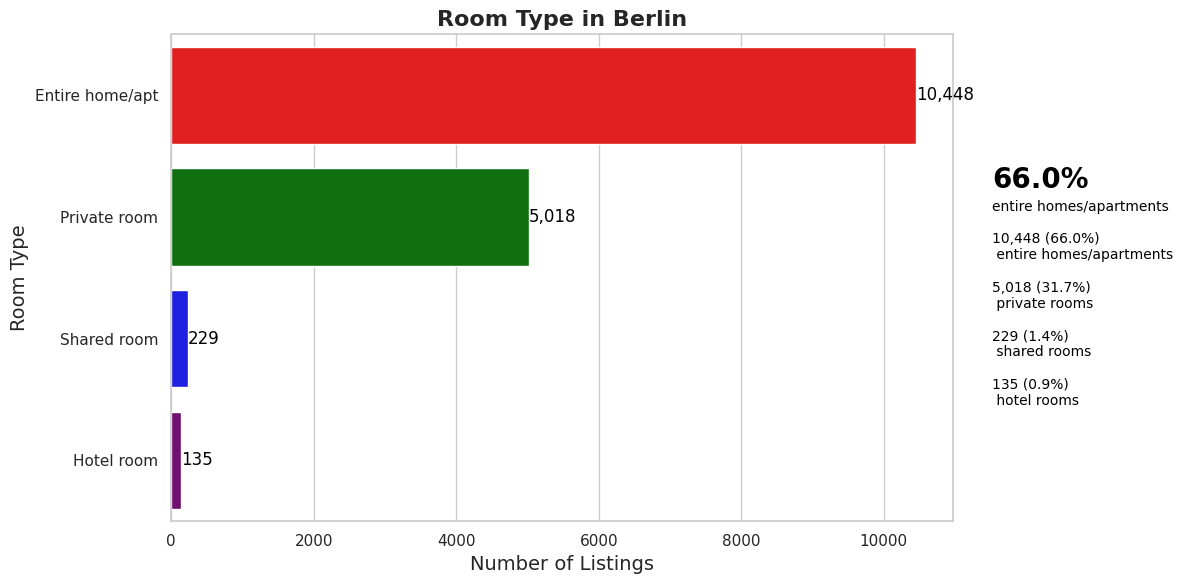

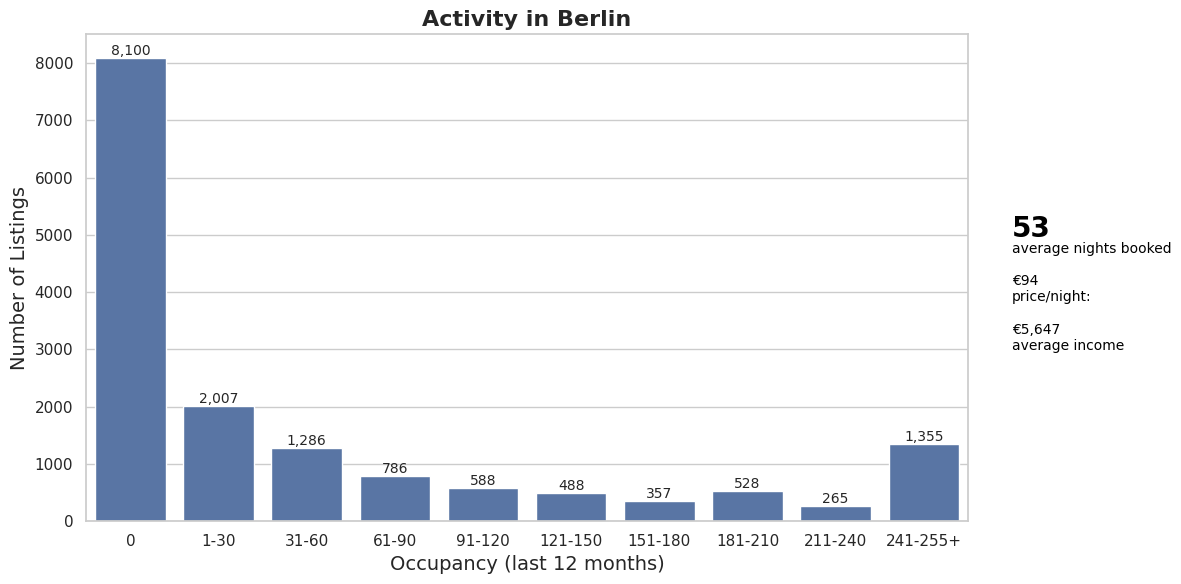

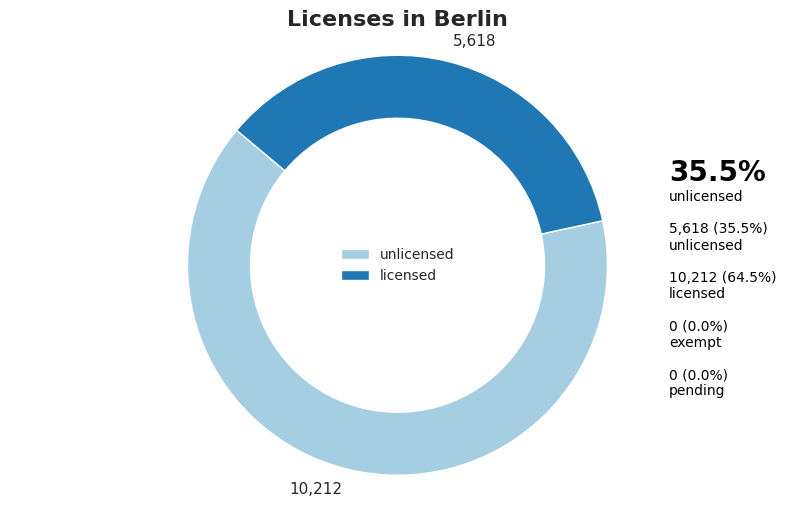

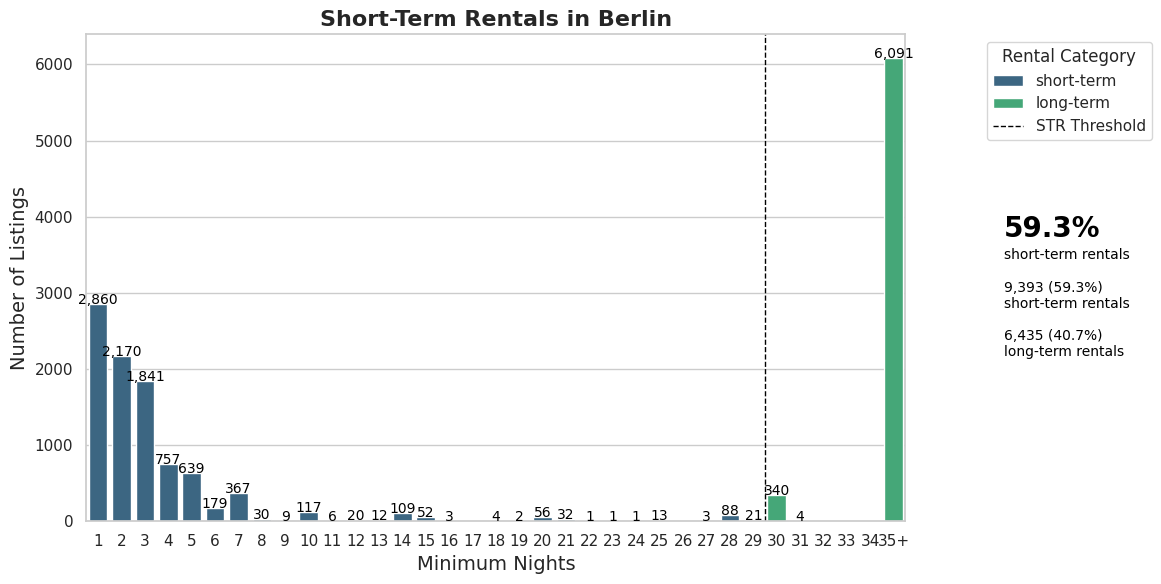

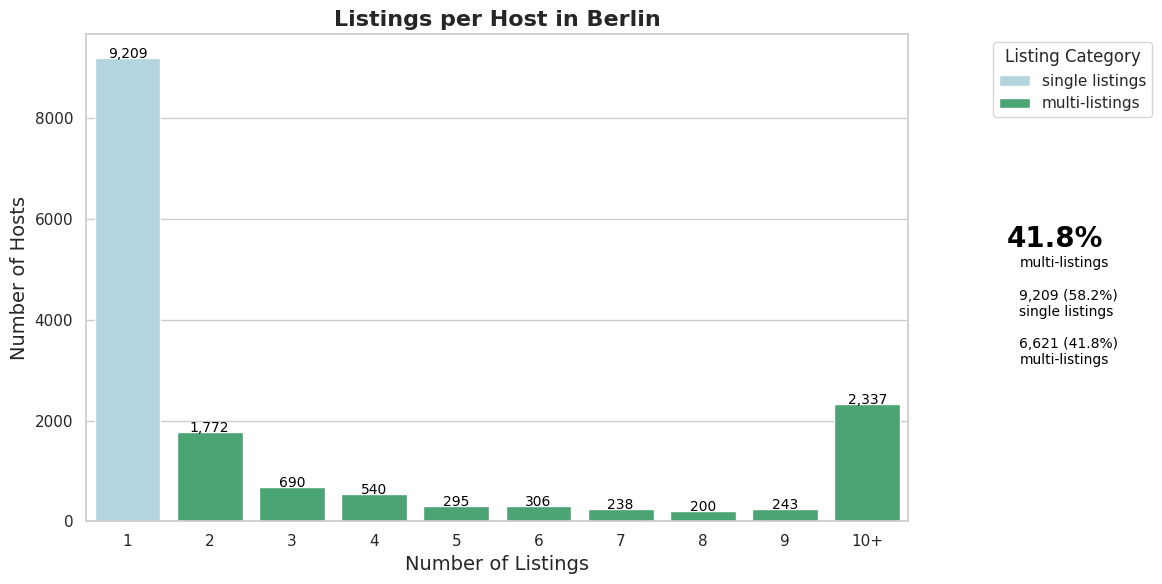

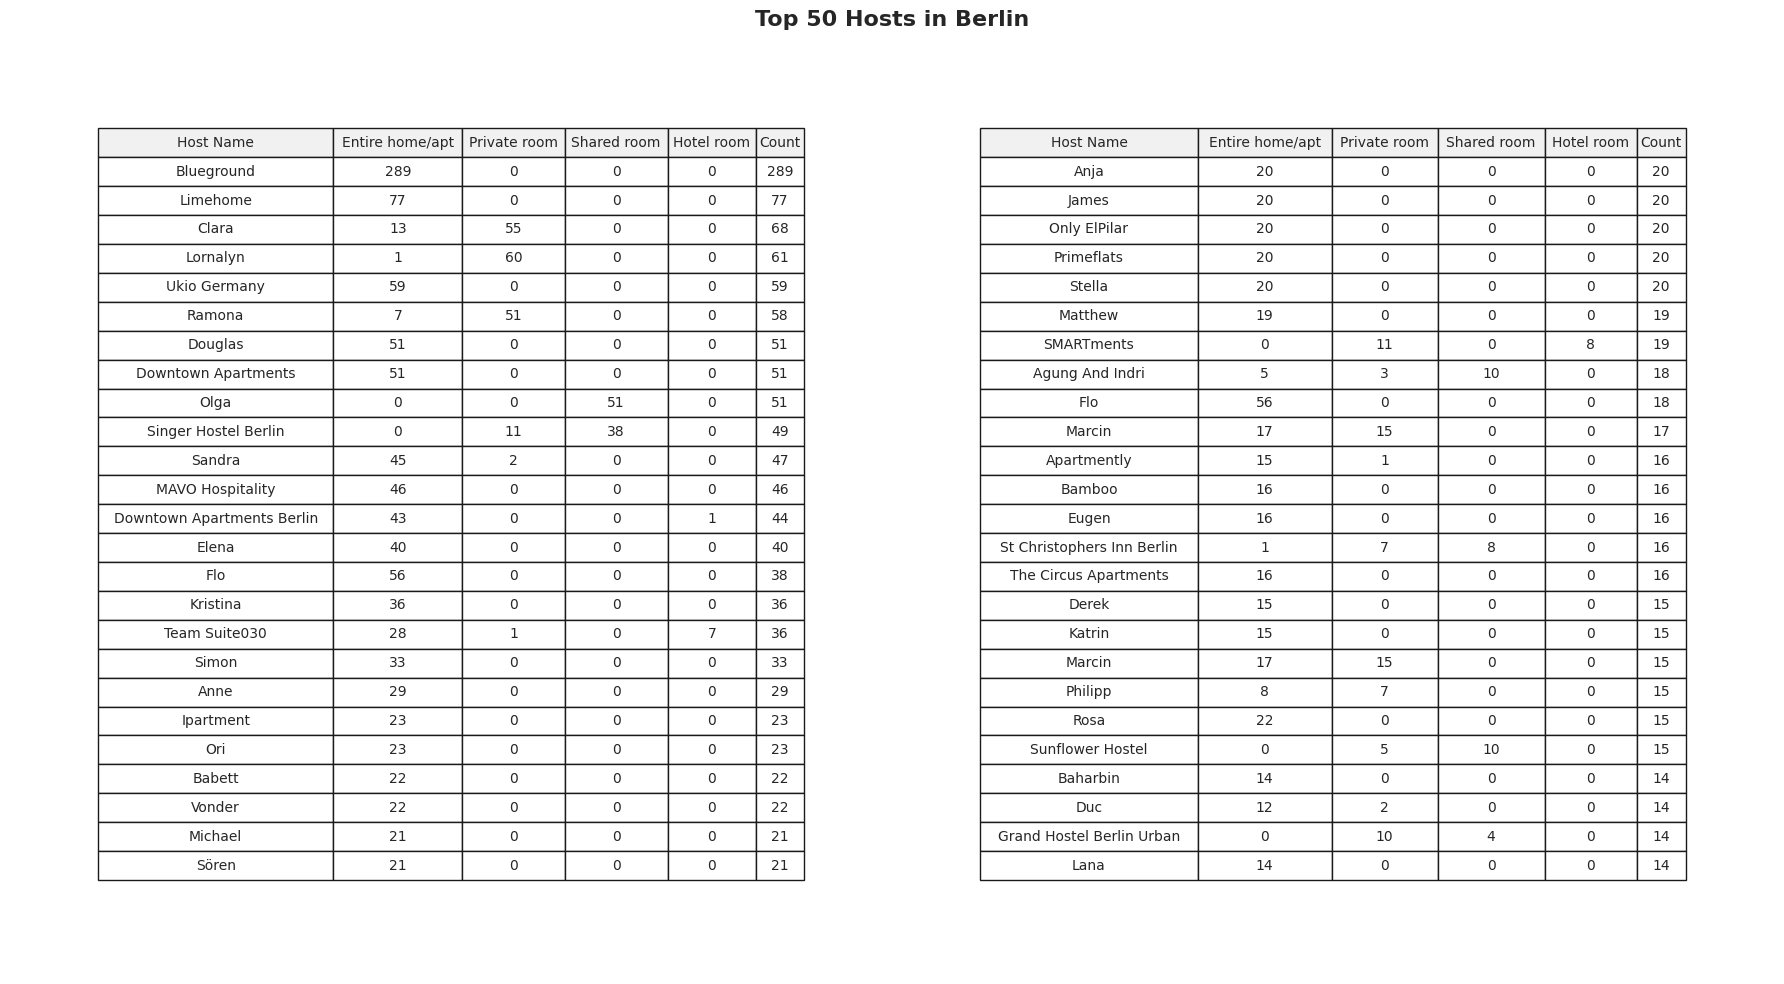

In [ ]:
interactive_output = widgets.interactive_output(
    update_plots,
    {
        'selected_city': city_dropdown,
        'only_entire_home_apt': room_type_checkbox,
        'only_unlicensed': license_checkbox,
        'only_short_term': short_term_rentals_checkbox,
        'only_multi_listings': multilistings_checbox
    }
)

display(controls, tabs)

**Note**: The visualizations have been tested using the data from the last quarter for each city and cross-validated with the plots on each city’s page on the Inside Airbnb explore page. The visualizations are identical, and all filtering options function correctly. However, there are minor discrepancies in some activity plots, particularly for larger cities, which may be due to additional assumptions or adjustments used by Inside Airbnb that are not disclosed.

## Submission Instructions

You must submit your assignment as a Jupyter notebook that will contain the full code and documentation of how you solved the questions. The Jupyter notebook must be fully replicable: that is, somebody reading it must be able to do exactly what you did and obtain the same results.

The documentation must be at the level where somebody that has some knowledge of Python can understand exactly what you are doing and why. Your output must be as user-friendly as possible. That means that your output tables should not include zillions of columns that are not needed for your analysis.

## Honor Code

You understand that this is an individual assignment, and as such you must carry it out alone. You may seek help on the Internet, on ChatGPT/Gemini/etc., by Googling or searching in StackOverflow for general questions pertaining to the use of Python and pandas libraries and idioms. However, it is not right to ask direct questions that relate to the assignment and where people will actually solve your problem by answering them. You may discuss with your colleagues in order to better understand the questions, if they are not clear enough, but you should not ask them to share their answers with you, or to help you by giving specific advice.